In [4]:

import os
import numpy as np
import matplotlib.ticker
import matplotlib.pyplot as plt
import re
import scipy.signal as signal
#path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-08 IN" #24-07\2024-07-24_11-09-09test_Homodyne.txt"

from scipy.optimize import curve_fit


In [5]:
def get_paths_homodyne(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "homodyne" in e]

def get_paths_intensity(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if e.endswith("esa.txt")]#[directory + "\\" + e for e in filenames if e.endswith("esa.txt")][:-10]

def get_OSA_paths(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "OSA" in e][:-10]


def get_data(path,length=1):

    return np.loadtxt(path, encoding = "unicode_escape",skiprows=1,delimiter=' ')

def plot_data(path,figure_no=1):

    header = get_header(path)[0]
    xs, ys = get_data(path)
    plt.figure(figure_no)
    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    

def ratio_to_db(feedback_power,output_power,):

    if (feedback_power == 0.0) or (feedback_power == 0):
        feedback_power = 0.000003 #0.003 nW (minimum for feedback PM)
    if (output_power == 0.0) or (output_power == 0):
        output_power = 0.000003

    return 10*np.log10(feedback_power/output_power)

def linear_to_dB(datapoint_linear):

    return 10*np.log10(datapoint_linear)


def dB_to_linear(power):
    pow_lin = 10**(power/10)
    return pow_lin

def OSA_fb_dB(feedback_power,peak_power,):

    peak_power_uW = 10**(peak_power/10)*1000 * 40 #in µW, multiplied by 40 to get correct value

    if feedback_power == 0.0:
        feedback_power = 0.000003 #0.003 nW (minimum for feedback PM)

    fb_dB = ratio_to_db(feedback_power,peak_power_uW)

    return fb_dB


def convert_optical_to_electrical(power, ret_V = False, conversion=371.7*1e-3/208): #Use power directly from PM (i.e. not multiplied by 40), and return average optical power squared in dBm


    # conversion = 371.7*1e-3/208 #V/µW      #307.4*1e-3/104.9 #V/µW      Conversion rate of PM power in µW to volts

    volts = conversion*power #V     Convert optical PM power to volts in ESA

    if ret_V:
        return volts
    
    else:

        elec_power = volts**2/50 #V^2/Ohm = W/Hz        Convert to electrical power

        elec_power_mW = 1e3*elec_power #mW/Hz           Make it mW

        power_sq_dBm = 10*np.log10(elec_power_mW/1) # 10*log10( [P/1mW]^2 ) [dBm]       Take the average power, square it and make it into dBm

        return power_sq_dBm
        


def convert_optical_to_electrical2(power, ret_V = False, conversion=1.9/1950): #Use power directly from PM (i.e. not multiplied by 40), and return average optical power squared in dBm

    #power = 1020 #Same for all as it is the EDFA who determines this

    #conversion = 1.9/1950 #V/µW

    volts = conversion*power #V     Convert optical PM power to volts in ESA

    if ret_V:
        return volts
    
    else:

        elec_power = volts**2/50 #V^2/Ohm = W/Hz        Convert to electrical power

        elec_power_mW = 1e3*elec_power #mW/Hz           Make it mW

        power_sq_dBm = 10*np.log10(elec_power_mW/1) # 10*log10( [P/1mW]^2 ) [dBm]       Take the average power, square it and make it into dBm

        return power_sq_dBm




def get_header(path,length=1):
    lines = []
    with open(path,encoding="ISO-8859-1") as file:
        for i in range(length):
            line = file.readline()
            lines.append(line[1:].split(','))
    return lines


def esa_header_data(header):

    length = len(header[0])
    
    output_power = float(header[0][0].split(" ")[1][:-2])*40 

    fb_level = float(header[0][1].split(" ")[3][:-2])
    
    if length == 6:
        gain = header[0][2][1:]

        pol = header[0][3].split(" ")[2]

        if 'MHz' in header[0][4].split(" ")[1]:
            rbw = float(header[0][4].split(" ")[1][4:-3])*1e6
        elif 'kHz' in header[0][4].split(" ")[1]:
            rbw = float(header[0][4].split(" ")[1][4:-3])*1e3
        else:
            rbw = float(header[0][4].split(" ")[1][4:-2])
        
    elif length == 5:
        pol = header[0][2].split(" ")[2]

        if 'MHz' in header[0][3].split(" ")[1]:
            rbw = float(header[0][3].split(" ")[1][4:-3])*1e6
        elif 'kHz' in header[0][3].split(" ")[1]:
            rbw = float(header[0][3].split(" ")[1][4:-3])*1e3
        else:
            rbw = float(header[0][3].split(" ")[1][4:-2])

        gain = 'None'

    if pol == 'Misaligned':
        pol = 'misaligned'

    if pol == 'Aligned':
        pol = 'aligned'

    if pol == 'None':
        pol='none'


    return output_power, fb_level, gain, pol, rbw


def thermal_noise_PSD():

    background_path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN\2024-09-10_16-02-20esa_background.txt"

    x,y = get_data(background_path)
    # plot_data(background_path)

    y_lin = dB_to_linear(y) #mW

    return x,y_lin


def thermal_noise_PSD2(x_max):

    if x_max == 1e5:
        background_path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\2024-09-24_18-10-52esa.txt"


    elif x_max ==1e7:
        background_path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\2024-09-24_18-11-24esa.txt"


    elif x_max ==1e8:
        background_path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\2024-09-24_18-11-51esa.txt"
        

    x,y = get_data(background_path)
    # plot_data(background_path)

    if x_max == 1e5: #xs has 50 datapoints pr. bandwidth, should be reduced to 2
            xs_new = [] #Only has two datapoints pr bandwidth.
            ys_new = [] #Only has two datapoints pr bandwidth.
            for j,hertz in enumerate(x):
                if j%25 ==0: #2 pr. bandwidth, and final datapoint is included (1e5)
                    xs_new.append(hertz)
                    ys_new.append(y[j])
            x = np.array(xs_new)
            y = np.array(ys_new)

    y_lin = dB_to_linear(y) #mW

    return x,y_lin



def shot_noise_PSD(power):
    
    Voltage_avg = convert_optical_to_electrical(power,ret_V=True)*1000 # mV
    q  = 1.602*1e-19 # [C]
    shot_noise = 2*Voltage_avg*q #mW/Hz

    return shot_noise


def shot_noise_PSD2(power):
    
    Voltage_avg = convert_optical_to_electrical2(power,ret_V=True)*1000 # mV
    q  = 1.602*1e-19 # [C]
    shot_noise = 2*Voltage_avg*q #W/Hz

    return shot_noise


def scientific(x, pos):
    if x == 1e5:
        return r'$10^5$'
    elif x == 1e6:
        return r'$10^6$'
    elif x == 1e7:
        return r'$10^7$'
    else:
        return r'$%d \times 10^{%d}$' % (int(x / (10**int(np.log10(x)))), int(np.log10(x)))

In [6]:
Voltage_avg = 5000*1*1e-3

elec_power_w = (Voltage_avg**2/50)

ratio_to_db(shot_noise_PSD2(0),elec_power_w)

-52.21848749616356

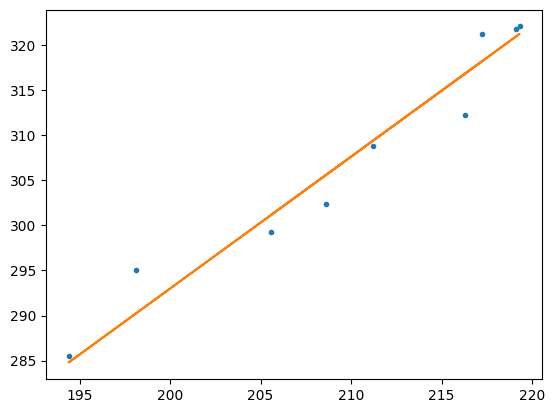

In [7]:
def lin_func(x,a):

    return x*a

power_uW = np.array([217.2,211.2,194.4,198.1,219.1,219.3,216.3,208.6,205.6])
voltage_mV = np.array([321.31,308.86,285.55,295.06,321.86,322.09,312.31,302.36,299.30])

popt,pcov = curve_fit(lin_func,power_uW,voltage_mV)
conversion_factor = popt[0]
conversion_offset = 0

plt.plot(power_uW,voltage_mV,'.')
# plt.plot(power_uW,power_uW*1.4+14)
plt.plot(power_uW,lin_func(power_uW,popt[0]))

In [ ]:
def plot_OSA_data(directory):

    plt.figure(0)

    paths = get_OSA_paths(directory)

    paths_esa = get_paths_intensity(directory)

    peak_wavelengths = [0 for _ in paths]
    gain = [0 for _ in paths]
    fb_level = [0 for _ in paths]

    labels = ['40mA, or','40mA, al','60mA, or','60mA, al','80mA, or','80mA, al','110mA, or','110mA, al']


    for i, path in enumerate(paths):

        header = get_header(path,length=5)

        esa_header = get_header(paths_esa[i],length=1)


        peak_power, _, _, pol, _ = esa_header_data(esa_header)

        peak_wavelengths[i] = float(header[0][0].split(" ")[3])

        
        #peak_power = float(esa_header[0][0].split(" ")[1][:-2])*40    #float(header[1][0].split(" ")[3]) #in dBm

        #pol = esa_header[0][3].split(" ")[2]


        #gain_fb_list = header[4][0].split("_")

        # if len(gain_fb_list) < 2:

        #     gain_fb_list = header[4][0].split(" ")

        #     print(gain_fb_list)
            
        #     gain[i] = float(gain_fb_list[2])

        #     fb_level[i] = 0

        # else:

        #     gain[i] = float(gain_fb_list[0])

        #     if i in range(4,8):
        #         fb_level[i] = float(gain_fb_list[2][:-3])

        #     else:
        #         fb_level[i] = float(gain_fb_list[2][:-2])

        gain_fb_list = header[4][0].split(" ")

        
        gain[i] = float(gain_fb_list[2])

        fb_uW = float(header[2][0].split(" ")[2])

        fb_level[i] =  ratio_to_db(fb_uW,peak_power) #OSA_fb_dB(fb_uW,peak_power)


        if gain[i] == 40:

            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'c.', label= labels[0])

                labels[0] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'b.', label= labels[1])

                labels[1] = "_nolegend_"


        elif gain[i] == 60:

            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'.',color='tab:orange', label= labels[2])

                labels[2] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'r.', label= labels[3])

                labels[3] = "_nolegend_"
    

        elif gain[i] == 80:
            
            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'.',color='tab:olive', label= labels[4])
                
                labels[4] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'g.', label= labels[5])

                labels[5] = "_nolegend_"


        elif gain[i] == 110:

            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'.',color = 'tab:brown', label= labels[6])

                labels[6] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'k.', label= labels[7])

                labels[7] = "_nolegend_"
    

        #print(gain_fb_list,fb_level)


def plot_rel_osc_data(directory):
    plt.figure()
    paths = get_paths_homodyne(directory)

    for i,path in enumerate(paths):

        header = get_header(path)

        output_power, fb_level, gain, pol, rbw = esa_header_data(header)

        fb_ratio = ratio_to_db(fb_level,output_power)



        xs, ys = get_data(path)
        plt.plot(xs*1e-9,ys-max(ys),alpha=1-i/20, label=f'fb: {fb_ratio:.0f} dB, {pol[:2]}')

        # if len(header)>3:
        #     plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
        # else:
        #     plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    plt.ylabel('Contrast [dB]')
    plt.legend() #['Pol.: Coherent peak height', 'Pol.: Relaxation oscillation peak height', 'Pol.: Moved and broad relaxaction oscillation'])
    plt.xlim(0,5)
    #plt.savefig(r'./Rel_osc_freq_DSH.pdf')
    #plt.savefig(r'./Rel_osc_freq_DSH.png')

def plot_int_data(figure_no):

    plt.figure(figure_no)
    header = get_header(path,length=1)[0]
    xs, ys = get_data(path)

    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')


def plot_intensity_data(directory):

    paths = get_paths_intensity(directory)#[:-10]

    fb_counter = [0,0,0,0,0,0,0,0]

    no_fb_rel_osc = [0,0,0,0,0,0]
    
    colors = ['#377eb8','#4daf4a','#ff7f00', '#e41a1c',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']

    for i, path in enumerate(paths):

        header = get_header(path,length=1)
        print(path)

        power, fb_level, gain, pol, rbw = esa_header_data(header)
        print(power)

        if '26-09' in directory:
            rbw_db = 10*np.log10(rbw) #Hz
        else:
            rbw_db = 10*np.log10(rbw) #MHz to Hz #Changed MHz calculation in extraction of bandwidth


        
        # if i <8:
        #     gain = header[2][1:-1]
        # else:
        #     gain = header[2][1:]

        #power = float(header[0].split(" ")[1][:-2])

        fb_dB = ratio_to_db(fb_level,power)


        xs, ys = get_data(path) #Hz, dBm

        ys += -rbw_db #dBm/Hz   Remove raw data dependence on bandwidth 

        print("dB", ys)

        ys_lin = dB_to_linear(ys) #Make data linear

        print("lin",ys_lin)
        
        noise_free_y = abs(ys_lin-shot_noise_PSD(power/40)/(rbw) - thermal_noise_PSD()[1]/(rbw)) #Remove shot noise and thermal noise from data, divide with bandwidth
        #divide with bandwidth in thermal noise? Same with shot noise?
        
        print("noise_free",noise_free_y)

        ys = 10*np.log10(ys_lin) #dBm/Hz    Make data into log scale 

        print("not noise free dB",ys)

        # power=110*40

        if '26-09' in directory:
            ys += -convert_optical_to_electrical(power/40,conversion=352*1e-3/99.2)  #Divide with the average optical power (in dB here, so subtract)
        else:
            ys += -convert_optical_to_electrical(power/40)  #Divide with the average optical power (in dB here, so subtract)

        print("divided with P_0^2", ys, any(np.isnan(ys)))

        if gain== 'Gain: 110mA':
            
            print(gain,fb_dB)
            plt.figure(8, figsize=(9.6,4.8),dpi=100)

            pol = pol[:2]
            
            for levels in [-9,-24,-93]:
                if abs(fb_dB-levels)<2:

                    plt.plot(xs*1e-9,ys, color=colors[fb_counter[7]],alpha = 1-fb_counter[7]/10,label=f'fb: {fb_dB:.1f} dB'+ ',' + pol) #alpha=1-fb_counter[7]/10)
                    # plt.axvline(5)
                    # plt.axvline(5.2)
                    # plt.axvline(5.4)
                    # plt.axvline(5.6)
                    fb_counter[7] +=1
            # plt.axvline(x=4.2, color = 'b', label = '_nolegend_')
            # plt.axvline(x=4.4, color = 'b', label = '_nolegend_')

            # plt.axvline(x=4.9, color = 'b', label = '_nolegend_')
            # plt.axvline(x=5, color = 'b', label = '_nolegend_')                
            # plt.axvline(x=5.6, color = 'b', label = '_nolegend_')
            # plt.axvline(x=8.8, color = 'b', label = '_nolegend_')
            plt.grid()

        elif pol=="Orthogonal":

            plt.figure(7)

            pol = pol[:2]

            plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[6]/20)

            fb_counter[6] +=1


        else:

            pol = pol[:2]

            if fb_dB < -80: # < 0.0001*0.2:

                plt.figure(1)
                
                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB', alpha=1-fb_counter[0]/10)




                index = np.where(ys==np.max(ys[10000:-20000]))

                print(xs[index])
                no_fb_rel_osc[fb_counter[0]] = xs[index][0]

                print(f'Between {xs[10000]*1e-9:.2f} and {xs[-20000]*1e-9:.2f} GHz')


                print(f'{gain}, Rel. osc.: {no_fb_rel_osc[fb_counter[0]]*1e-9:.2f} GHz, fb: {fb_dB:.0f} dB\n')

                #plt.axvline(x=no_fb_rel_osc[fb_counter[0]]*1e-9, color = 'b', label = '_nolegend_')
                
                plt.axvline(x=1.3, color = 'b', label = '_nolegend_')
                plt.axvline(x=1.4, color = 'b', label = '_nolegend_')

                plt.axvline(x=2.6, color = 'b', label = '_nolegend_')
                plt.axvline(x=3.9, color = 'b', label = '_nolegend_')                
                plt.axvline(x=5.6, color = 'b', label = '_nolegend_')

                fb_counter[0] +=1


            elif fb_dB < -41: #<10*0.2:

                plt.figure(2)
                

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+',' +pol, alpha=1-fb_counter[1]/10)


                fb_counter[1] +=1



            elif fb_dB< -35: #<100*0.2:

                plt.figure(3)

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[2]/10)
                
                fb_counter[2] +=1




            elif fb_dB < -27.5: #  < 920*0.2:
                

                plt.figure(4)


                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+',' +pol, alpha=1-fb_counter[3]/10)



                if gain == 'Gain: 40mA':

                    rel_osc = xs[np.where(ys==np.max(ys[20:-20000]))][0]
                    print(f'Between {xs[20]*1e-9:.4f} and {xs[-20000]*1e-9:.2f} GHz')

                else:

                    rel_osc = xs[np.where(ys==np.max(ys[15000:-20000]))][0]

                    print(f'Between {xs[15000]*1e-9:.2f} and {xs[-20000]*1e-9:.2f} GHz')

                        

                    print(gain)

                    print(f'100µW fb, Rel. osc.: {rel_osc*1e-9:.2f} GHz \n')

                    #plt.axvline(x=rel_osc*1e-9, color = 'b', label = '_nolegend_')

            
                fb_counter[3] +=1

                


            elif fb_dB < -20: # >= 920*0.2:
                
                plt.figure(5)
                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[4]/10)

                fb_counter[4] +=1




            elif fb_dB > -20: # >= 920*0.2:

                
                plt.figure(6)

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[5]/20)

                fb_counter[5] +=1



    list_fb = ['None','-49dB','-39dB', '-29dB','-26dB','-9dB','-9dB,orthogonal','110mA gain']
    save_path = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\Measurement spectra and plots\RIN\29-8"
    for i in range(8):
        plt.figure(i+1)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        # plt.legend()
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('RIN [dBc/Hz]')
        plt.ylim([-160,-91])
        plt.xlim([0,10])
        plt.xticks([0,1,2,3,4,5,6,7,8,9,10])

        #plt.xscale('log')

        if i==7:

            plt.legend(['No FB','Aligned -9 dB','Aligned -22 dB', 'Misaligned -9 dB'],loc=(0.015,0.89),handletextpad=0.3,handlelength=0.95,ncol=4,mode='expand',markerscale=50,fontsize=15)

            plt.savefig(fr'{save_path}\\RIN_gain_fb_{list_fb[i]}_15pt_font.pdf',bbox_inches='tight')
            plt.savefig(fr'{save_path}\RIN_gain_fb{list_fb[i]}_15pt_font.png',bbox_inches='tight')



def plot_intensity_data2(directory):

    paths = get_paths_intensity(directory)

    no_RIN_values = int(len(paths))

    single_RIN_values = [None for _ in range(no_RIN_values)]
    fb_powers = [None for _ in range(no_RIN_values)]
    polarizations = [None for _ in range(no_RIN_values)]
    

    fb_counter = [0,0,0,0,0,0,0,0]

    no_fb_rel_osc = [0,0,0,0,0,0]
    
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c','#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']

    for i, path in enumerate(paths):

        header = get_header(path,length=1)
        print(header)

        power, fb_level, gain, pol, rbw = esa_header_data(header)

        xs, ys = get_data(path) #Hz, dBm


        if xs.max() == 1e5: #xs has 50 datapoints pr. bandwidth, should be reduced to 2
            xs_new = [] #Only has two datapoints pr bandwidth.
            ys_new = [] #Only has two datapoints pr bandwidth.
            for j,hertz in enumerate(xs):
                if j%25 ==0: #2 pr. bandwidth, and final datapoint is included (1e5)
                    xs_new.append(hertz)
                    ys_new.append(ys[j])
            xs = np.array(xs_new)
            ys = np.array(ys_new)

        # elif rbw == 500: #xs has 5 datapoints pr bandwidth, should be reduced to 2
        #     xs_new = [] #Only has two datapoints pr bandwidth.
        #     ys_new = [] #Only has two datapoints pr bandwidth.
        #     for j,hertz in enumerate(xs):
        #         if j%2 ==0: #2.5 pr. bandwidth, and final datapoint is included (1e5)?
        #             xs_new.append(hertz)
        #             ys_new.append(ys[j])
        #     xs = np.array(xs_new)
        #     ys = np.array(ys_new)
                    
                
        if xs.max() == 1e7 and rbw == 50:
            rbw =100 #The rbw was set by ESA to 100Hz, as 1e5 datapoints is max, so 10MHz/100Hz = 1e5 datapoints


        if xs.max() == 1e7 and rbw == 500:
            fb_level = 2*fb_level


        rbw_db = 10*np.log10(rbw) #Hz
        
        # if i <8:
        #     gain = header[2][1:-1]
        # else:
        #     gain = header[2][1:]

        #power = float(header[0].split(" ")[1][:-2])

        fb_dB = ratio_to_db(fb_level,power)



        ys += -rbw_db #dBm/Hz   Remove raw data dependence on bandwidth 

        # print("dB", ys)

        # ys_lin = dB_to_linear(ys) #Make data linear

        # print("lin",ys_lin)

        power_EDFA = 1950 #roughly 1mW

        if pol != 'None':
            pass
            # noise_free_y = abs(ys_lin-shot_noise_PSD2(power_EDFA)/(rbw) - thermal_noise_PSD2(xs.max())[1]/(rbw)) #Remove shot noise and thermal noise from data, divide with bandwidth
        #divide with bandwidth in thermal noise? Same with shot noise?
        else:
            pass
            # noise_free_y = ys_lin
        
        # print("noise_free",noise_free_y)

        # ys = 10*np.log10(ys_lin) #dBm/Hz    Make data into log scale 

        print("not noise free dB",ys)

        if xs.max()==1e10:
            ys += -convert_optical_to_electrical2(power,conversion=352*1e-3/99.2)  #The conversion rate for GHz is 352mV when outputting 99.2µW on powermeter.
        else: 
            ys += -convert_optical_to_electrical2(114,conversion= 232*1e-3/114)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]

        # print("divided with P_0^2", ys, any(np.isnan(ys)))

        if xs.max() == 1e5:
            plt.figure(0)
            plt.plot(xs*1e-3,ys, label = f'FB:{fb_dB:.1f}dB, {pol}', alpha = 1-.20*(i/3))
        elif xs.max() ==1e7: #and ((pol=='Background') or (pol=='Aligned')):
            plt.figure(1)
            plt.plot(xs*1e-6,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)

            if pol =='Background':
                plt.figure(2)
                plt.plot(xs,ys, color = '#e41a1c', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)

            if abs(-73-fb_dB)<1: #  or pol=='Orthogonal':
                plt.figure(2)
                plt.plot(xs,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
                
            
            print(pol,fb_dB)
            if pol == "Orthogonal" and abs(-8-fb_dB)<1:
                plt.figure(6)
                plt.plot(xs,ys, color = '#e41a1c', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
            elif pol == "Aligned" and abs(-8-fb_dB)<1:
                plt.figure(6)
                plt.plot(xs,ys, color = '#4daf4a', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.9)
            # elif pol == "Aligned" and abs(-73-fb_dB)<1:
            #     plt.figure(6)
            #     plt.plot(xs,ys, color = '#377eb8', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)

            # elif pol == "Aligned" and abs(-21-fb_dB)<1:
            #     plt.figure(6)
            #     plt.plot(xs,ys, color = '#ff7f00', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)



            if fb_dB >-26:
                pass
            # elif fb_dB >-40:
                # plt.figure(2)
                # plt.plot(xs*1e-6,ys, label = f'FB:{fb_dB:.1f}dB',alpha = 1)
            else:
                plt.figure(3)
                plt.plot(xs*1e-6,ys, label = f'FB:{fb_dB:.1f}dB',alpha = 1)

        elif xs.max() ==1e8:
            plt.figure(4)
            plt.plot(xs*1e-6,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1-.20*((i-2)/3))

        elif xs.max() ==1e10:
            plt.figure(5)
            plt.plot(xs*1e-9,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)


        diff = xs[1]-xs[0]
        print(xs[20000])
        single_RIN_values[i] = linear_to_dB( sum( dB_to_linear(ys[20000:]) ) * diff ) #Hz, summing all the datapoints and multiplying with the difference in xs, converting to dB
        fb_powers[i] = fb_dB
        polarizations[i] = pol

    
    for i in range(0,7):#range(3)
        plt.figure(i)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        plt.legend(fontsize=12)
        if i ==0:
            plt.xlabel('Frequency [kHz]')
            plt.xscale('log')
            plt.ylim([-180,-70])

        elif i==5:
            plt.xlabel('Frequency [GHz]')
            plt.ylim([-190,-120])
        else:
            plt.xlabel('Frequency [Hz]')
            plt.xscale('log')
            plt.ylim([-145,-119])
            plt.xlim([3e5,1e7])
            plt.grid()

        plt.ylabel('RIN [dBc/Hz]')
        
        # plt.xlim([0,10])
        # plt.legend()
        plt.xscale('log')

        save_path = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\Measurement spectra and plots\RIN\29-8"

        if i==6:

            plt.legend(['Aligned -8 dB','Misaligned -8 dB'],loc=(0.005,0.005),handletextpad=0.3,handlelength=0.95,fontsize=18)

            plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz.pdf',bbox_inches='tight')
            plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz.png',bbox_inches='tight')

    return fb_powers, single_RIN_values, polarizations

def plot_intensity_data3(directory):  #Originally to distinguish between HP detector and Thorlabs 150MHz detector. This one was for Thorlabs detector.

    paths = get_paths_intensity(directory)

    no_RIN_values = int(len(paths))

    single_RIN_values = [None for _ in range(no_RIN_values)]
    fb_powers = [None for _ in range(no_RIN_values)]
    polarizations = [None for _ in range(no_RIN_values)]
    

    fb_counter = [0,0,0,0,0,0,0,0]

    no_fb_rel_osc = [0,0,0,0,0,0]
    
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c','#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']

    for i, path in enumerate(paths):

        header = get_header(path,length=1)
        # print(header)

        power, fb_level, gain, pol, rbw = esa_header_data(header)

        xs, ys = get_data(path) #Hz, dBm

                    
                
        if xs.max() == 1e7 and rbw == 50:
            rbw =100 #The rbw was set by ESA to 100Hz, as 1e5 datapoints is max, so 10MHz/100Hz = 1e5 datapoints


        if xs.max() == 1e7 and rbw == 100:
            fb_level = 2*fb_level


        rbw_db = 10*np.log10(rbw) #Hz
        

        fb_dB = ratio_to_db(fb_level,power)



        ys += -rbw_db #dBm/Hz   Remove raw data dependence on bandwidth 


        ys += -convert_optical_to_electrical2(power/40,conversion= 1.79/210)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]

        # print("divided with P_0^2", ys, any(np.isnan(ys)))

        if xs.max() ==1e7: #and (pol=='Background' or pol=='Aligned'):
            plt.figure(0)
            plt.plot(xs*1e-3,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)
            print(pol,fb_dB)
            if pol == "misaligned" and abs(-11-fb_dB)<1:
                plt.figure(1)
                plt.plot(xs,ys, color = '#e41a1c', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
            elif pol == "aligned" and abs(-11-fb_dB)<1:
                plt.figure(1)
                plt.plot(xs,ys, color = '#4daf4a', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.9)



        diff = xs[1]-xs[0]
        print(xs[2000])
        single_RIN_values[i] = linear_to_dB( sum( dB_to_linear(ys[2000:]) ) * diff ) #Hz, summing all the datapoints and multiplying with the difference in xs, converting to dB
        fb_powers[i] = fb_dB
        polarizations[i] = pol

    
    for i in range(0,2):#range(3)
        plt.figure(i)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        #plt.legend()
        if i ==0:
            plt.xlabel('Frequency [kHz]')
            plt.xscale('log')
            plt.ylim([-160,-80])
            plt.grid()
        
        else:
            plt.xlabel('Frequency [Hz]')
            plt.xscale('log')
            plt.ylim([-155,-115])
            plt.xlim([3e5,1e7])
            plt.grid()

        plt.ylabel('RIN [dBc/Hz]')
        
        # plt.xlim([0,10])
        # plt.legend()
        plt.xscale('log')

        save_path = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\Measurement spectra and plots\RIN\22-01"

        if i==1:

            plt.legend(['Aligned -11 dB','Misaligned -11 dB'],loc=(0.005,0.005),handletextpad=0.3,handlelength=0.95,fontsize=18)

            plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz.pdf',bbox_inches='tight')
            plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz.png',bbox_inches='tight')

    return fb_powers, single_RIN_values, polarizations


def plot_intensity_data4(directory): #Originally to distinguish between HP detector and Thorlabs 150MHz detector. This one is for HP detector.

    paths = get_paths_intensity(directory)

    no_RIN_values = int(len(paths))

    single_RIN_values = [None for _ in range(no_RIN_values)]
    fb_powers = [None for _ in range(no_RIN_values)]
    polarizations = [None for _ in range(no_RIN_values)]
    

    fb_counter = [0,0,0,0,0,0,0,0]

    no_fb_rel_osc = [0,0,0,0,0,0]
    
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c','#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']
    
    if "Impedance matched" in directory: #Due to wrong impedance matching digitally by ESA an offset is added
            imp_match = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Background\Average_offset_imp_match.txt",skiprows=2)
            offset_imp = imp_match[0]

    for i, path in enumerate(paths):

        header = get_header(path,length=1)
        # print(header)

        power, fb_level, gain, pol, rbw = esa_header_data(header)

        

        xs, ys = get_data(path) #Hz, dBm

                    
                
        if xs.max() == 1e7 and rbw == 50:
            rbw =100 #The rbw was set by ESA to 100Hz, as 1e5 datapoints is max, so 10MHz/100Hz = 1e5 datapoints


        fb_level = 2*fb_level


        rbw_db = 10*np.log10(rbw) #Hz
        

        fb_dB = ratio_to_db(fb_level,power)

        power /= 40

        ys += -rbw_db #dBm/Hz   Remove raw data dependence on bandwidth 

        voltage_mV = conversion_factor*power + conversion_offset

        if '326.06mV220.0uW' in path:
            voltage_mV = 326.06 #Took no FB another day, as didn't save this properly for impedance matched. The "laser off" background was saved as "no FB".
        print(power,voltage_mV)

        # if power = 0

        ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]

        # print("divided with P_0^2", ys, any(np.isnan(ys)))

        if "Impedance matched" in directory:
            ys -= offset_imp #To combat digital conversion by ESA
        
        if ((pol=='none') or (pol=='misaligned') or (pol=='aligned')): 
            plt.figure(0)
            plt.plot(xs,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
        print(pol,fb_dB)
        if pol == "misaligned" and abs(-7.5-fb_dB)<1:
            plt.figure(1)
            plt.plot(xs,ys, color = '#e41a1c', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
        elif pol == "aligned" and abs(-7.5-fb_dB)<1:
            plt.figure(1)
            plt.plot(xs,ys, color = '#4daf4a', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)
        elif pol == 'none' and power>0:
            plt.figure(1)
            plt.plot(xs,ys, color = '#377eb8', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1) # colors = ['#377eb8','#4daf4a','#ff7f00', '#e41a1c']



        diff = xs[1]-xs[0]
        print(xs[10])
        single_RIN_values[i] = linear_to_dB( sum( dB_to_linear(ys[10:]) ) * diff ) #Hz, summing all the datapoints and multiplying with the difference in xs, converting to dB
        fb_powers[i] = fb_dB
        polarizations[i] = pol

    
    for i in range(0,2):#range(3)
        plt.figure(i)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        # plt.legend()
        if i ==0:
            plt.xlabel('Frequency [Hz]')
            plt.xscale('log')
            # plt.ylim([-155,-110])
            plt.grid()
            plt.xlim([1e3,1e7])
        
        else:
            plt.xlabel('Frequency [Hz]')
            plt.xscale('log')
            plt.ylim([-147,-107])
            plt.xlim([1e3,1e7])
            plt.grid()

        plt.ylabel('RIN [dBc/Hz]')
        
        # plt.xlim([0,10])
        # plt.legend()
        plt.xscale('log')

        save_path = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\Measurement spectra and plots\RIN\22-01"

        if i==1:

            plt.legend(['No FB','Aligned -7.5 dB','Misaligned -7.5 dB'],loc=(0.5525,0.405),handletextpad=0.3,handlelength=0.95,fontsize=14)

            plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz_HP.pdf',bbox_inches='tight')
            plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz_HP.png',bbox_inches='tight')

    return fb_powers, single_RIN_values, polarizations

misaligned -11.074480044479644
200000.0
misaligned -11.074480044479644
200000.0
misaligned -11.074480044479644
200000.0
aligned -11.130967741013318
200000.0
aligned -11.130967741013318
200000.0
aligned -11.130967741013318
200000.0


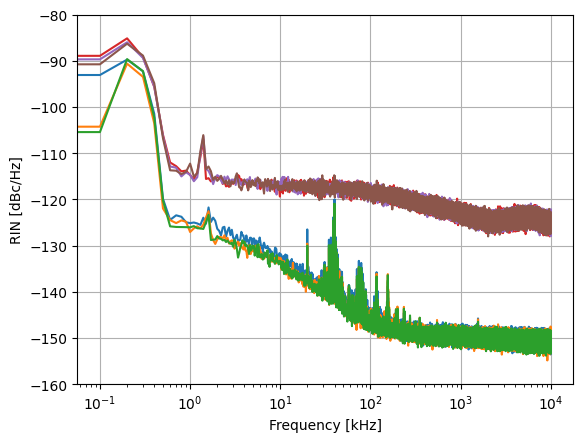

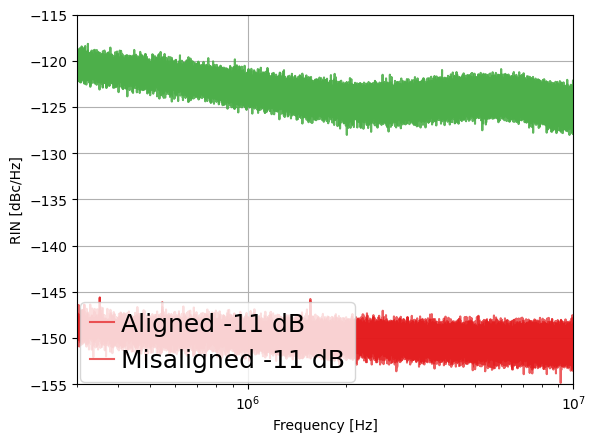

In [9]:
_,_,_ = plot_intensity_data3(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\RIN")

219.0 320.82512758645964
aligned -11.112744123010174
1000.0
219.0 320.82512758645964
aligned -11.112744123010174
1000.0
219.0 320.82512758645964
aligned -11.112744123010174
1000.0
221.0 323.75503742743183
misaligned -11.076031742758177
1000.0
221.0 323.75503742743183
misaligned -11.076031742758177
1000.0
221.0 323.75503742743183
misaligned -11.076031742758177
1000.0
0.0 0.0
none 0.0
1000.0


C:\Users\au617810\AppData\Local\Temp\ipykernel_17444\3281075268.py:763: RuntimeWarning: invalid value encountered in scalar divide
  ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]


0.0 0.0
none 0.0
1000.0


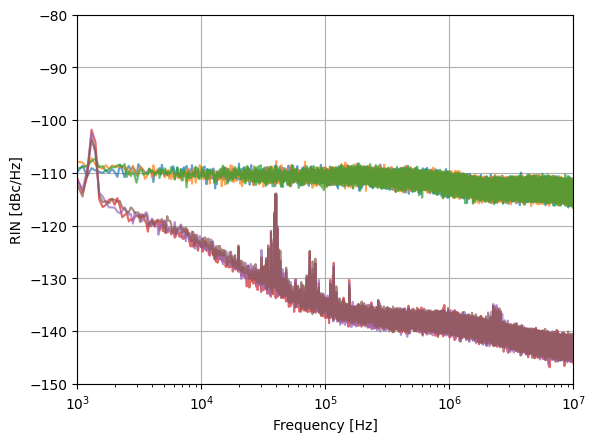

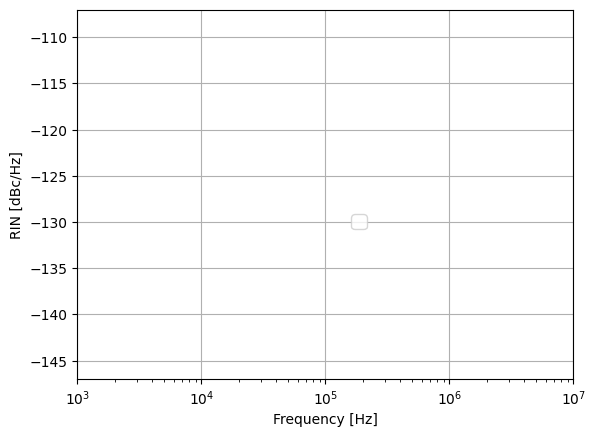

In [10]:
_,_,_ = plot_intensity_data4(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP detector RIN")

0.0 0.0
none 0.0
1000.0


C:\Users\au617810\AppData\Local\Temp\ipykernel_17444\3281075268.py:763: RuntimeWarning: invalid value encountered in scalar divide
  ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]


160.2 234.68577826187592
none -93.29601248356519
1000.0
160.2 234.68577826187592
misaligned -7.348404957700558
1000.0
161.0 235.85774219826484
misaligned -10.317491548556394
1000.0
160.9 235.71124670621623
misaligned -13.326544462345682
1000.0
160.4 234.97876924597318
misaligned -16.405382996960554
1000.0
161.1 236.00423769031343
misaligned -19.738455308781177
1000.0
161.4 236.44372416645928
misaligned -22.731526557224726
1000.0
161.0 235.85774219826484
misaligned -25.0310471610483
1000.0
160.2 234.68577826187592
aligned -73.29601248356519
1000.0
160.2 234.68577826187592
aligned -62.96177492869569
1000.0
159.8 234.09979629368152
aligned -52.91620585905285
1000.0
160.4 234.97876924597318
aligned -43.02114376956201
1000.0
160.2 234.68577826187592
aligned -32.95106482507043
1000.0
160.5 235.12526473802177
aligned -29.84974691126161
1000.0
160.8 235.56475121416761
aligned -26.386716016815882
1000.0
160.2 234.68577826187592
aligned -23.19018639912455
1000.0
160.2 234.68577826187592
aligned 

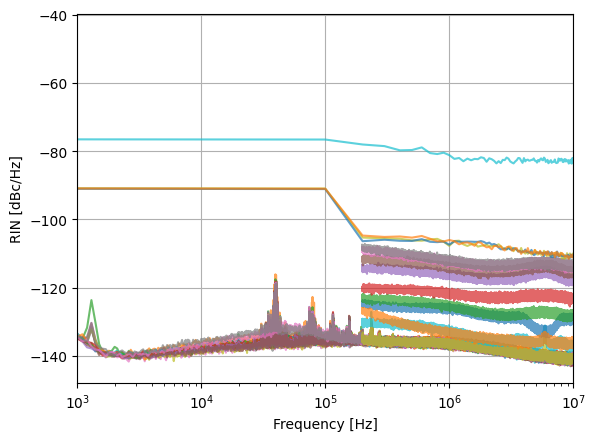

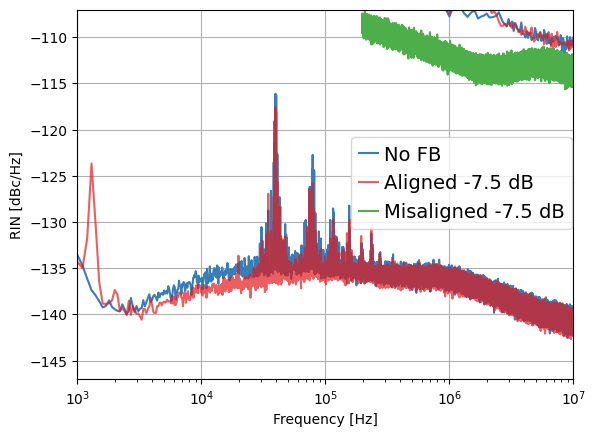

In [11]:
_,_,_ = plot_intensity_data4(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN new\MHz")

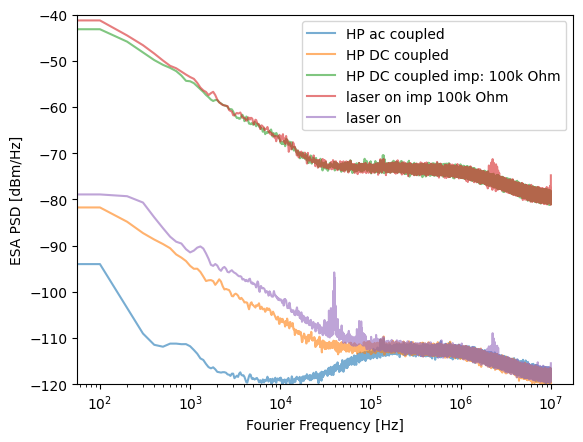

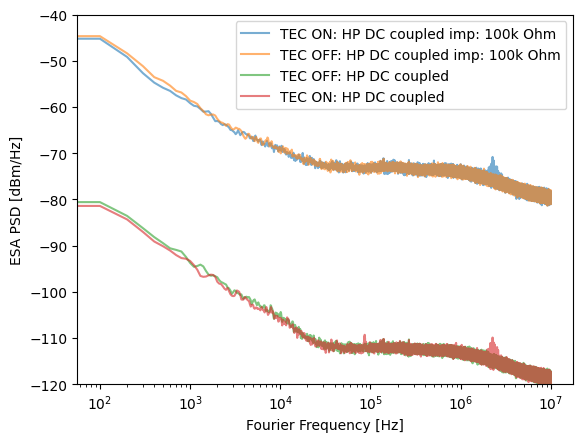

In [12]:
background_path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Background\Data"

backgrounds = os.listdir(background_path)

background_data = []
background_header =[]

for back in backgrounds[:3]:
    plt.figure(0)

    path = background_path + '//'+back

    header_data = get_header(path)
    data = np.loadtxt(path)
    background_data.append(data)
    background_header.append(header_data)
    
    plt.plot(data[0],data[1],alpha=0.6,label=header_data[0][2][6:])
    plt.legend(fontsize=10)
    plt.ylim([-120,-40])
    plt.xscale('log')
    plt.xlabel('Fourier Frequency [Hz]')
    plt.ylabel('ESA PSD [dBm/Hz]')

    # plt.savefig(r'.\\AC_DC_coupling.pdf')

laser_on_imp = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Impedance matched\2025-01-30_21-13-03-004065esa.txt",skiprows=1)
laser_on = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Mismatch impedance\2025-01-30_19-03-21-140002esa.txt",skiprows=1)

plt.plot(laser_on_imp[0],laser_on_imp[1],alpha=0.6,label='laser on imp 100k Ohm')
plt.plot(laser_on[0],laser_on[1],alpha=0.6,label='laser on')
plt.legend(fontsize=10)

for back in backgrounds[4:]:
    plt.figure(1)

    path = background_path + '//'+back

    header_data = get_header(path)
    data = np.loadtxt(path)
    background_data.append(data)
    background_header.append(header_data)
    
    plt.plot(data[0],data[1],alpha=0.6,label=header_data[0][2][6:])
    plt.legend(fontsize=10)
    plt.ylim([-120,-40])
    plt.xscale('log')
    plt.xlabel('Fourier Frequency [Hz]')
    plt.ylabel('ESA PSD [dBm/Hz]')

    # plt.savefig(r'.\\TEC_on_off.pdf')



Text(0, 0.5, 'Difference [dB]')

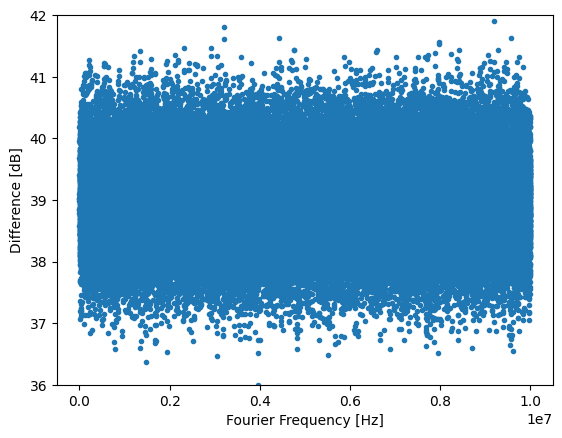

In [13]:
plt.plot(background_data[1][0],background_data[2][1]-background_data[1][1],'.')

plt.ylim([36,42])
# plt.xscale('log')
plt.xlabel('Fourier Frequency [Hz]')
plt.ylabel('Difference [dB]')

# plt.savefig(r'.\\DC_Imp_diffence_linear.pdf')

In [14]:
averages = np.array([np.average(background_data[2][1]-background_data[1][1]), np.average(background_data[2][1])-np.average(background_data[1][1]), np.average(background_data[2][1]-background_data[1][1]) - (np.average(background_data[2][1])-np.average(background_data[1][1]))])

# np.savetxt(r'.\\Average_offset_imp_match.txt',averages,header='DC coupled with 100k Ohm impedance and 50 Ohm impedance \nAvg(100k Ohm - 50 Ohm), Avg(100k Ohm) - Avg(50 Ohm), Difference between the two')

220.2 326.06
none -94.67756051244032
1000.0
201.6 295.41348477720794
aligned -7.481880270062003
1000.0
208.1 304.9382251098064
aligned -9.151515590358091
1000.0
209.7 307.2827765762922
aligned -10.778165143715487
1000.0
211.6 310.0669314427441
aligned -12.277379288238649
1000.0
214.1 313.73029310912807
aligned -13.903492758484264
1000.0
215.7 316.07484457561384
aligned -15.795018093915264
1000.0
216.4 317.10058584220144
aligned -17.577654565973067
1000.0
216.6 317.3936547755121
aligned -18.673111218771442
1000.0
219.3 321.3500853752069
aligned -20.426222516162284
1000.0
219.6 321.789688775173
aligned -21.49622743124384
1000.0
219.0 320.91048197524077
aligned -23.356929592491174
1000.0
219.5 321.6431543085176
aligned -25.209046760546205
1000.0
220.2 322.6688955751051
aligned -27.38591261551263
1000.0
220.2 322.6688955751051
aligned -32.9866969375701
1000.0
220.2 322.6688955751051
aligned -42.97885768486573
1000.0
220.6 323.2550334417266
aligned -52.920671175888444
1000.0
220.5 323.10849

C:\Users\au617810\AppData\Local\Temp\ipykernel_2688\3281075268.py:763: RuntimeWarning: invalid value encountered in scalar divide
  ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]


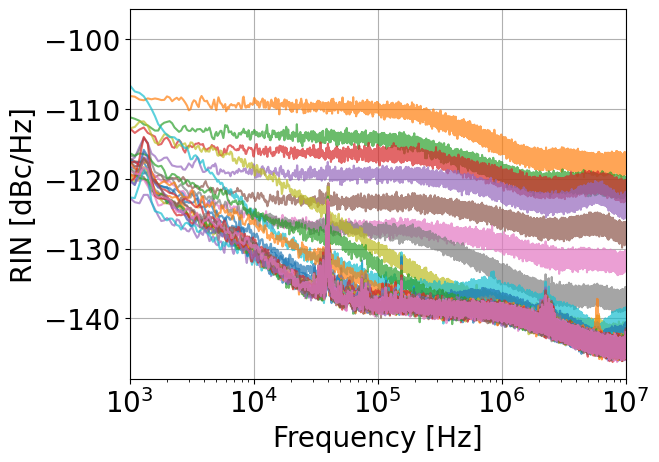

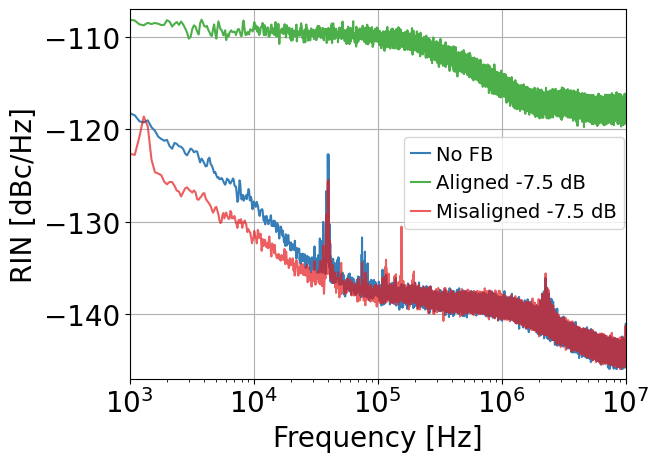

In [526]:
fb_powers_imp,single_RIN_values_imp,polarizations_imp = plot_intensity_data4(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Impedance matched")

0.0 0.0
none 0.0
1000.0


C:\Users\au617810\AppData\Local\Temp\ipykernel_2688\2253139278.py:763: RuntimeWarning: invalid value encountered in scalar divide
  ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]


0.0 0.0
none 0.0
1000.0
219.5 321.6431543085176
none -94.6637326118644
1000.0
220.1 322.5223611084498
aligned -72.45710029545292
1000.0
219.4 321.49661984186224
aligned -62.805387828850805
1000.0
220.0 322.3758266417944
aligned -52.845664720803185
1000.0
219.5 321.6431543085176
aligned -42.93575797170683
1000.0
219.2 321.2035509085515
aligned -32.831744459025025
1000.0
219.7 321.9362232418283
aligned -26.35539099661747
1000.0
219.8 322.0827577084837
aligned -23.29612313325039
1000.0
219.0 320.91048197524077
aligned -21.503926970809122
1000.0
218.1 319.59167177534255
aligned -20.32230638028013
1000.0
216.4 317.10058584220144
aligned -19.816294974489885
1000.0
215.4 315.6352411756478
aligned -18.853128333697825
1000.0
216.1 316.6609824422353
aligned -18.135166831792052
1000.0
215.9 316.36791350892463
aligned -17.16204545622138
1000.0
215.3 315.4887067089925
aligned -15.512886551710183
1000.0
213.7 313.14415524250666
aligned -13.845822055287284
1000.0
211.7 310.2134659093994
aligned -12.3

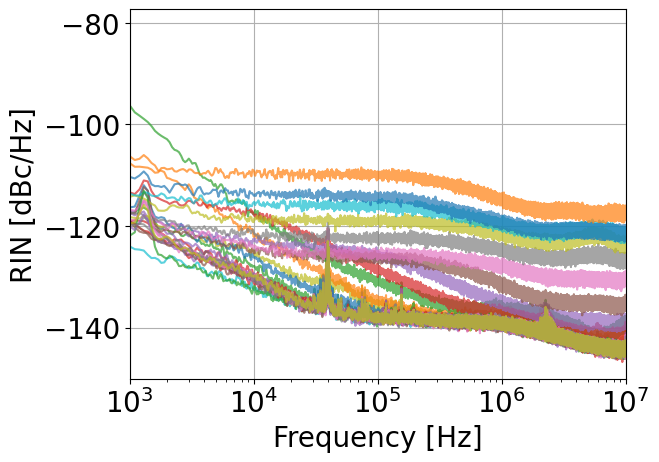

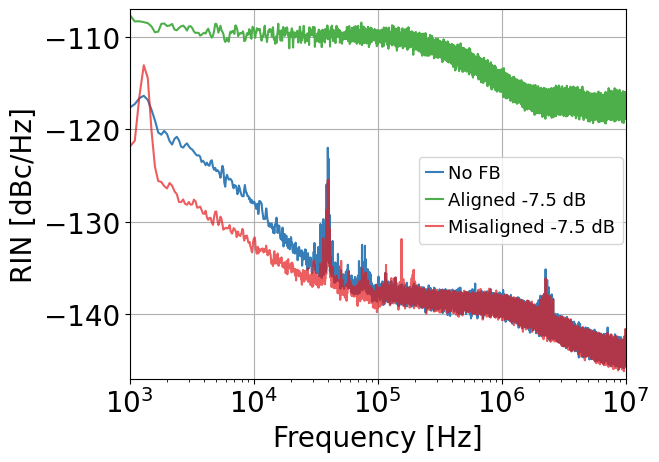

In [518]:
fb_powers_50imp,single_RIN_values_50imp,polarizations_50imp = plot_intensity_data4(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Mismatch impedance")

0.0
none 0.0
200000.0


C:\Users\au617810\AppData\Local\Temp\ipykernel_2688\2455979128.py:753: RuntimeWarning: invalid value encountered in scalar divide
  ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]


0.0
none 0.0
200000.0
12862.304201868106
none -94.6637326118644
200000.0
12897.463119959773
aligned -72.45710029545292
200000.0
12856.444382186162
aligned -62.805387828850805
200000.0
12891.60330027783
aligned -52.845664720803185
200000.0
12862.304201868106
aligned -42.93575797170683
200000.0
12844.724742822274
aligned -32.831744459025025
200000.0
12874.023841231996
aligned -26.35539099661747
200000.0
12879.88366091394
aligned -23.29612313325039
200000.0
12833.005103458385
aligned -21.503926970809122
200000.0
12780.266726320884
aligned -20.32230638028013
200000.0
12680.649791727828
aligned -19.816294974489885
200000.0
12622.051594908384
aligned -18.853128333697825
200000.0
12663.070332681995
aligned -18.135166831792052
200000.0
12651.350693318107
aligned -17.16204545622138
200000.0
12616.19177522644
aligned -15.512886551710183
200000.0
12522.434660315328
aligned -13.845822055287284
200000.0
12405.238266676439
aligned -12.326495516433484
200000.0
12299.761512401437
aligned -10.736712819

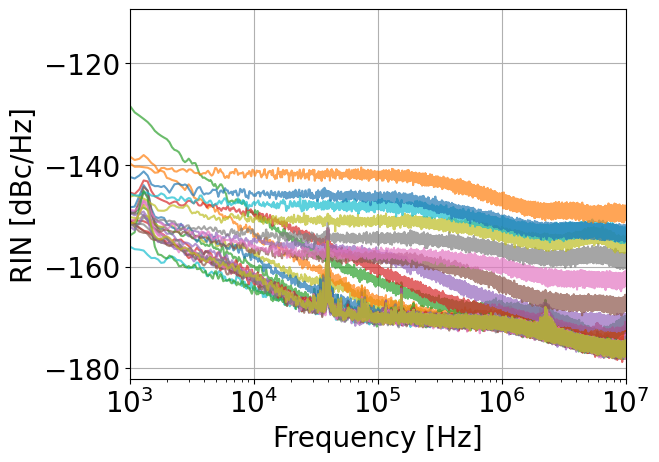

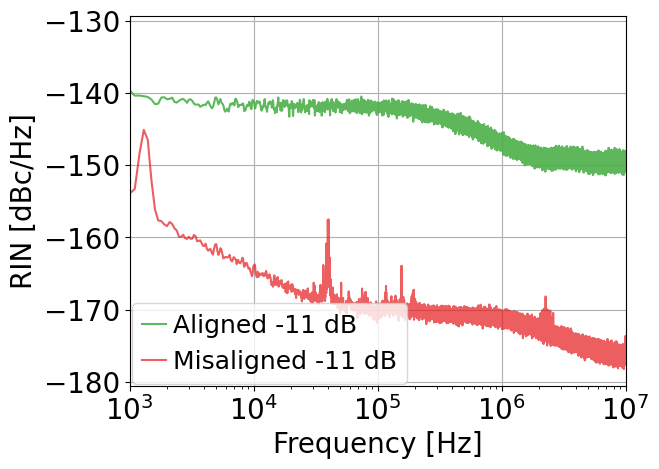

In [296]:
# fb_powers_imp,single_RIN_values_imp,polarizations_imp = plot_intensity_data4(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Mismatch impedance")

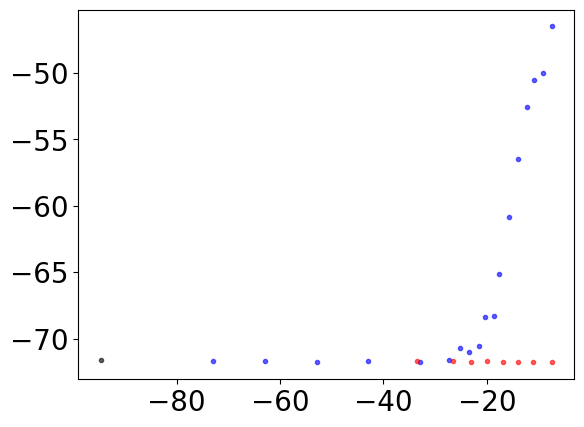

In [520]:
for i,polar in enumerate(polarizations_imp):
    
    if polar == 'misaligned':
        plt.plot(fb_powers_imp[i],single_RIN_values_imp[i],'r.',alpha=0.6,label='Misaligned')
        
    elif polar == 'aligned':
        plt.plot(fb_powers_imp[i],single_RIN_values_imp[i],'b.',alpha=0.6,label='Aligned')
    else:
        plt.plot(fb_powers_imp[i],single_RIN_values_imp[i],'k.',alpha=0.6,label='None')


# for i,polar in enumerate(polarizations_50imp):
    
#     if polar == 'misaligned':
#         plt.plot(fb_powers_50imp[i],single_RIN_values_50imp[i],'r.',alpha=0.6,label='Misaligned')
        
#     elif polar == 'aligned':
#         plt.plot(fb_powers_50imp[i],single_RIN_values_50imp[i],'b.',alpha=0.6,label='Aligned')
#     else:
#         plt.plot(fb_powers_50imp[i],single_RIN_values_50imp[i],'g.',alpha=0.6,label='None')

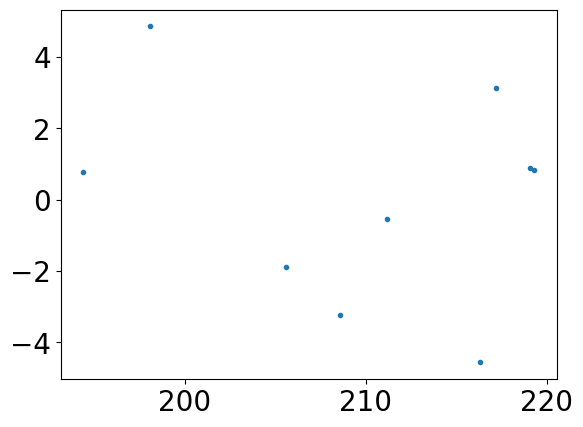

In [283]:
### Residuals

plt.plot(power_uW,voltage_mV-lin_func(power_uW,popt[0]),'.')

aligned -7.481880270062003
200000.0
aligned -9.151515590358091
200000.0
aligned -10.778165143715487
200000.0
aligned -12.277379288238649
200000.0
aligned -13.903492758484264
200000.0
aligned -15.795018093915264
200000.0
aligned -17.577654565973067
200000.0
aligned -18.673111218771442
200000.0
aligned -20.426222516162284
200000.0
aligned -21.49622743124384
200000.0
aligned -23.356929592491174
200000.0
aligned -25.209046760546205
200000.0
aligned -27.38591261551263
200000.0
aligned -32.9866969375701
200000.0
aligned -42.97885768486573
200000.0
aligned -52.920671175888444
200000.0
aligned -62.92256071356476
200000.0
aligned -73.00437371762285
200000.0
aligned -7.4274892891460595
200000.0
aligned -10.98718388959129
200000.0
aligned -13.890576229025042
200000.0
aligned -16.855641896962442
200000.0
aligned -19.990140870183488
200000.0
aligned -22.998498468891245
200000.0
aligned -26.466155087221132
200000.0
aligned -33.59868026061234
200000.0
none -94.60396637297684
200000.0
none 0.0
200000.

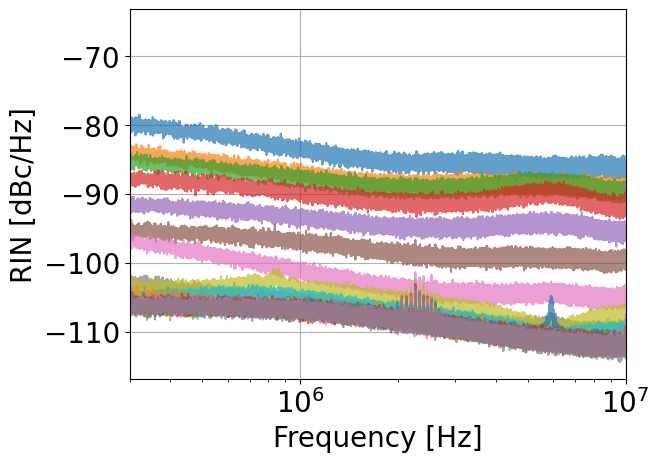

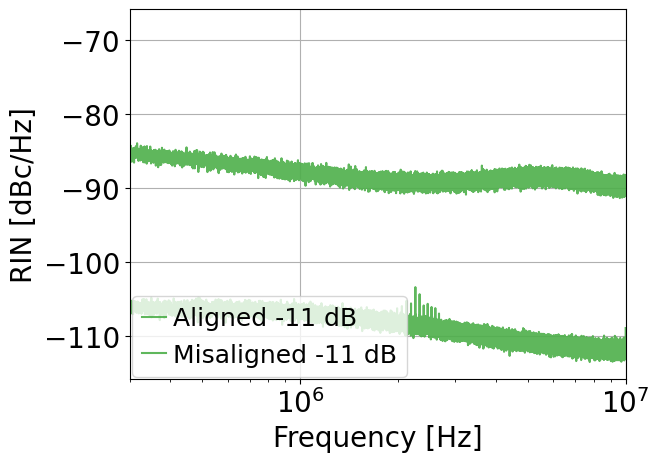

In [207]:
_,_,_ = plot_intensity_data4(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\FN and RIN measurements\HP RIN DC Block\Impedance matched")

In [59]:
test = [[' 219uW output', ' fb = 342uW', ' Wavelength: None nm', ' rbw=100Hz', ' counts=20\n']]


In [19]:
directory = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN" #r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-07"

directory2 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN" #r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN" #r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-07"

paths_homodyne = get_paths_homodyne(directory)
print(len(paths_homodyne))

paths_intensity = get_paths_intensity(directory)
print(len(paths_intensity))

10
40


In [61]:
list((10**(get_data(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN\2024-08-29_16-28-43esa.txt")[1]/10)/1e7)-(thermal_noise_PSD()[1]/1e7))

[2.4795329701081173e-09,
 2.4886787975832555e-09,
 2.4976552585384e-09,
 2.490434197356676e-09,
 2.503067063693719e-09,
 2.4974117315613613e-09,
 2.492215879671355e-09,
 2.4881183036834015e-09,
 2.4924396603910255e-09,
 2.4773148645816783e-09,
 2.47012205627133e-09,
 2.4702319966358042e-09,
 2.4573020907193086e-09,
 2.446830924123771e-09,
 2.437791841206173e-09,
 2.424329118988352e-09,
 2.4185141212002795e-09,
 2.4001462353804366e-09,
 2.3926117888039857e-09,
 2.37808854955231e-09,
 2.3467136182951643e-09,
 2.3146713706951046e-09,
 2.29495148375308e-09,
 2.2711781809500473e-09,
 2.236708018159016e-09,
 2.219425895760275e-09,
 2.1676156143069095e-09,
 2.1406566743027476e-09,
 2.1109025711136948e-09,
 2.0818860037994396e-09,
 2.042245305057811e-09,
 2.005919843798819e-09,
 1.9687863461647972e-09,
 1.9337794985834645e-09,
 1.9030943857541446e-09,
 1.8591292657913193e-09,
 1.829619510158754e-09,
 1.7912942273988647e-09,
 1.7532828228869841e-09,
 1.7134681552071318e-09,
 1.6726867065310832e

In [62]:
(thermal_noise_PSD()[1]/1e7)

array([2.77345306e-09, 2.78475949e-09, 2.78101285e-09, ...,
       5.73737889e-16, 8.51108732e-16, 7.69994422e-16])

In [63]:
for path in paths_intensity:

    header = get_header(path)

    output_power, fb_level, gain, pol, rbw = esa_header_data(header)

    ratio = ratio_to_db(fb_level,output_power)

    #print(f'{ratio:.0f}')

    

    


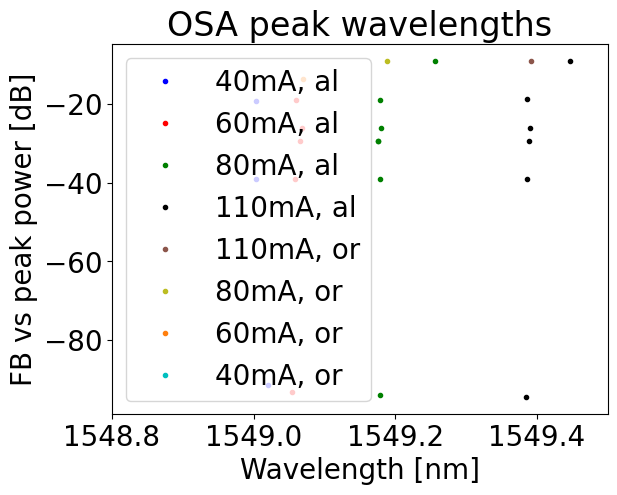

In [64]:
plot_OSA_data(directory)
plt.xlim([1548.8,1549.5])
plt.figure(0)
#plt.legend(['40mA','60mA','80mA','110mA'])
plt.xlabel('Wavelength [nm]')
plt.ylabel('FB vs peak power [dB]')
plt.title('OSA peak wavelengths')
plt.legend()

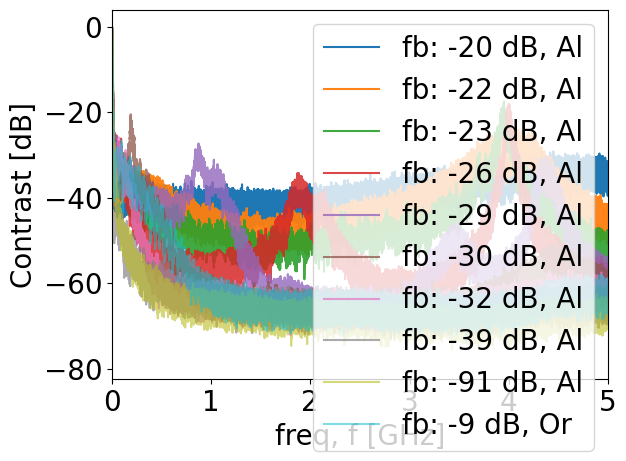

In [65]:
plot_rel_osc_data(directory)

O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN\2024-08-29_16-14-37esa.txt
1280.0
dB [ -82.83522511  -82.83132744  -82.82155037 ... -148.77951813 -149.31550598
 -149.67250061]
lin [5.20568026e-09 5.21035430e-09 5.22209734e-09 ... 1.32448849e-15
 1.17071020e-15 1.07832566e-15]
noise_free [2.43222719e-09 2.42559481e-09 2.44108449e-09 ... 7.50750595e-16
 3.19601465e-16 3.08331233e-16]
not noise free dB [ -82.83522511  -82.83132744  -82.82155037 ... -148.77951813 -149.31550598
 -149.67250061]
divided with P_0^2 [ -70.99110915  -70.98721148  -70.97743441 ... -136.93540217 -137.47139003
 -137.82838466] False
[1.1632e+09]
Between 1.00 and 8.00 GHz
Gain: 30mA, Rel. osc.: 1.16 GHz, fb: -86 dB

O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN\2024-08-29_16-24-52esa.txt
4160.0
dB [ -82.77442265  -82.76478958  -82.75324154 ... -149.29623413 -150.34922791
 -149.31822968]
lin [5.27907383e-09 5.29079631e-09 5.30488

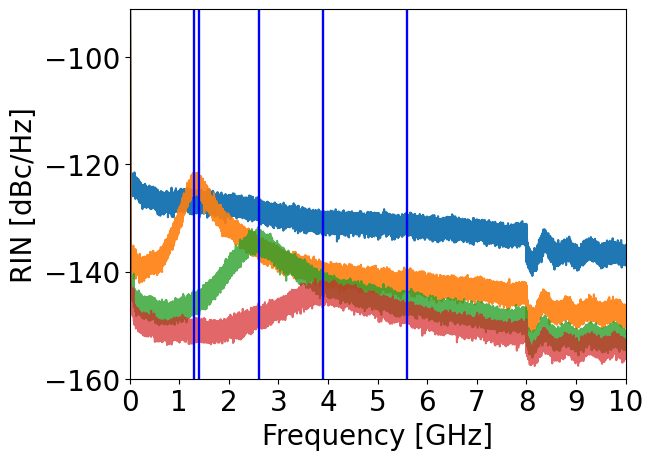

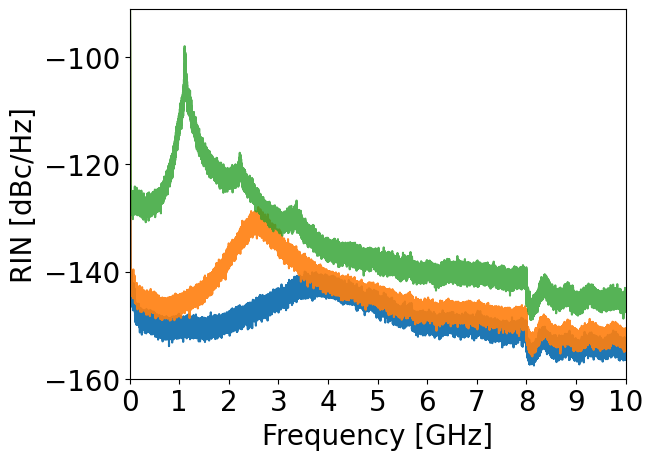

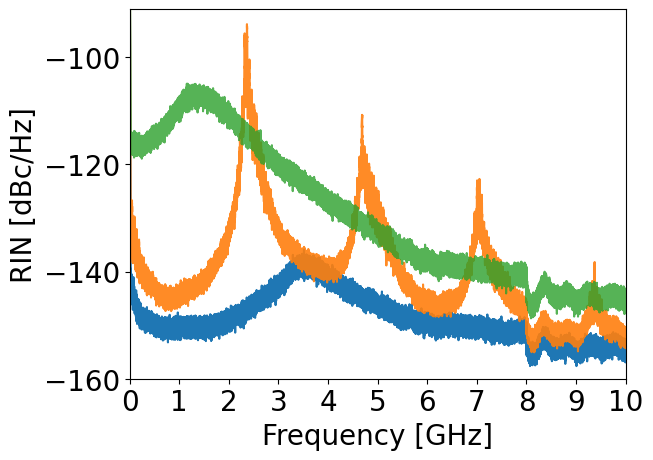

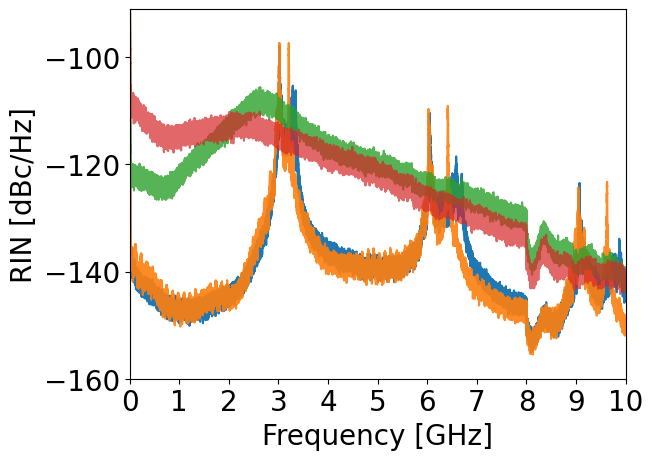

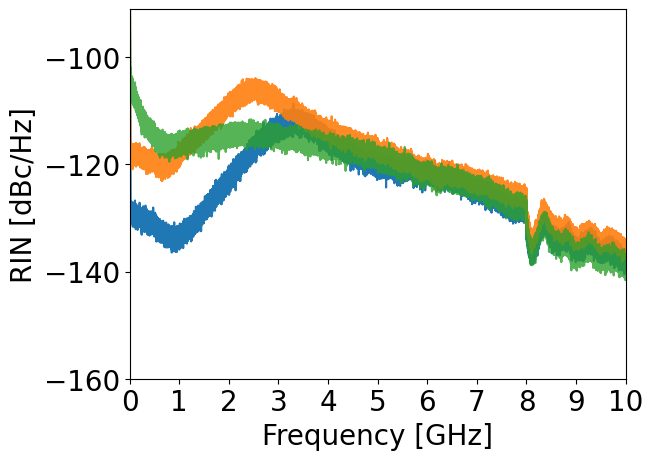

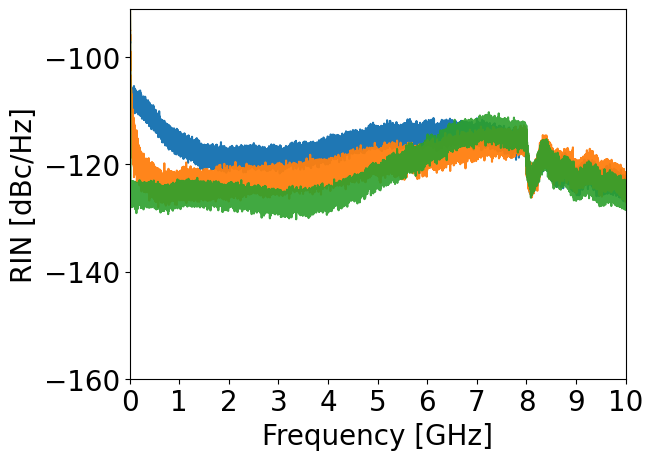

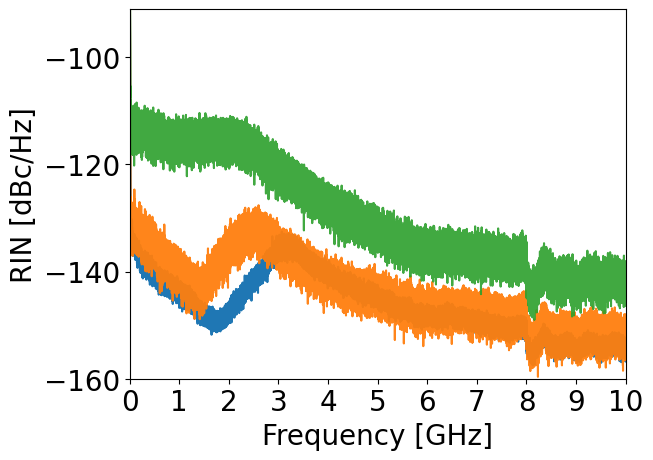

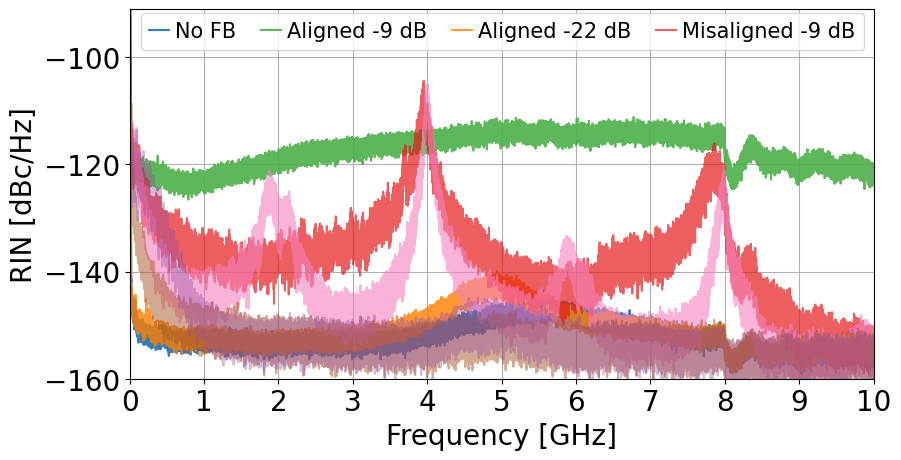

In [20]:
#GHz RIN measurements
plt.rcParams.update({'font.size': 20})

plot_intensity_data(directory)

O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-09 GHz\2024-09-26_17-08-45esa.txt
3948.0
dB [ -83.17752266  -83.16203213  -83.14770412 ... -150.73471069 -150.31711578
 -150.95328522]
lin [4.81113711e-09 4.82832825e-09 4.84428390e-09 ... 8.44362488e-16
 9.29583533e-16 8.02918525e-16]
noise_free [2.03768405e-09 2.04356875e-09 2.06327106e-09 ... 2.70624592e-16
 7.84747945e-17 3.29240972e-17]
not noise free dB [ -83.17752266  -83.16203213  -83.14770412 ... -150.73471069 -150.31711578
 -150.95328522]
divided with P_0^2 [ -87.0747855   -87.05929496  -87.04496696 ... -154.63197353 -154.21437862
 -154.85054805] False
Gain: 110mA -91.19255889277937
O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-09 GHz\2024-09-26_17-11-48esa.txt
4404.0
dB [ -83.28363991  -83.26933384  -83.30262566 ... -120.53643417 -120.55695724
 -120.75090408]
lin [4.69500446e-09 4.71049575e-09 4.67452444e-09 ... 8.83805261e-13
 8.79638594e-13 8.412200

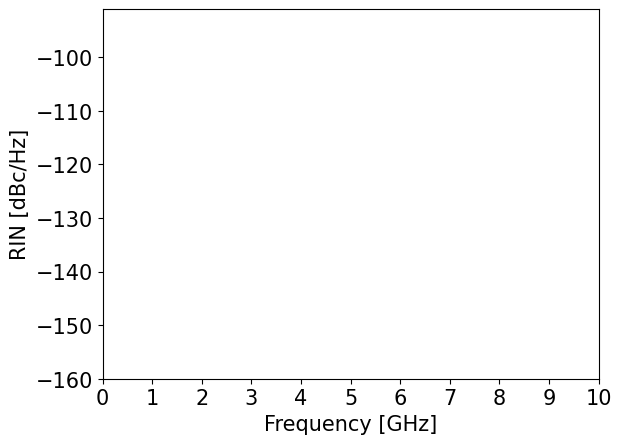

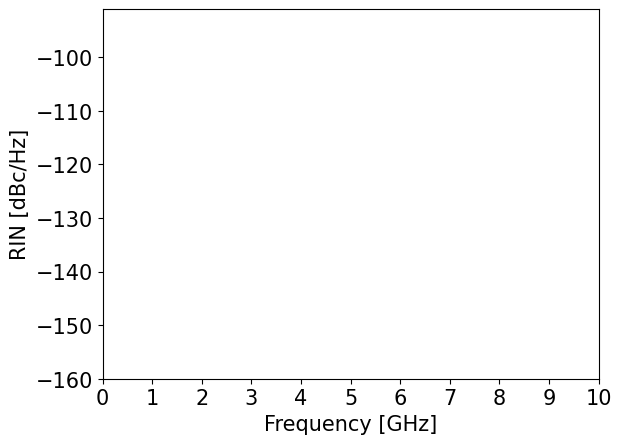

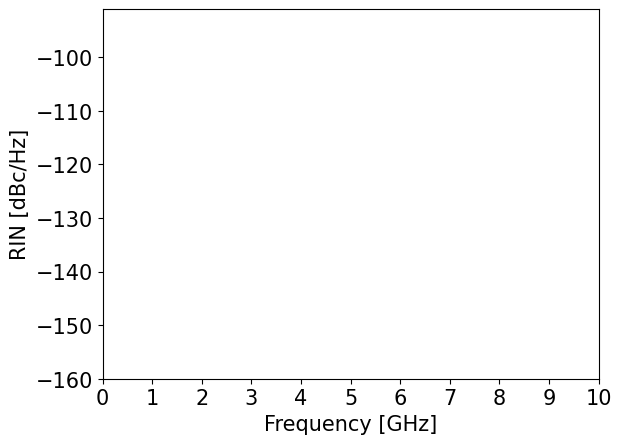

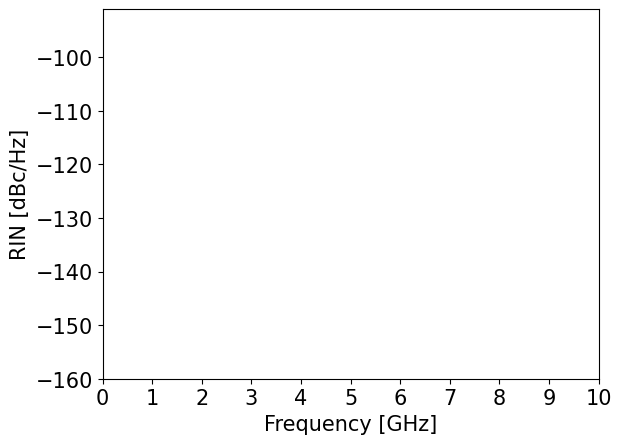

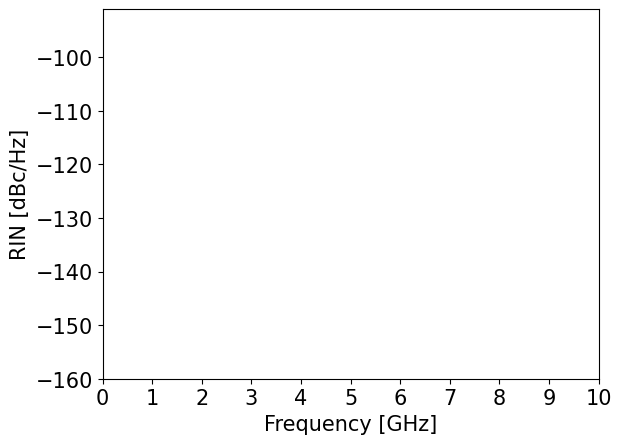

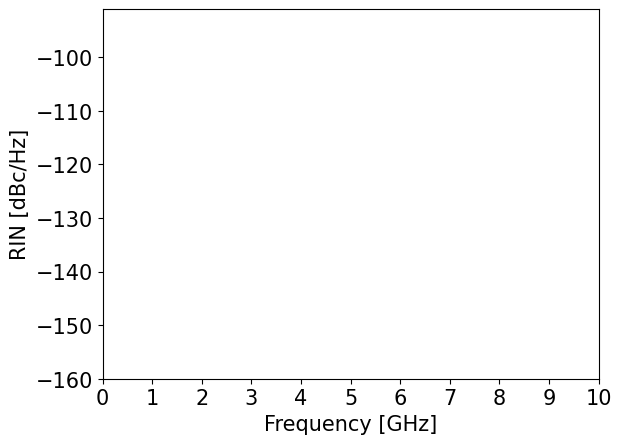

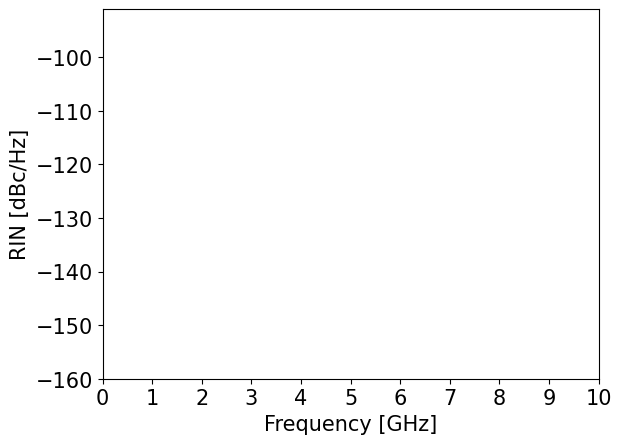

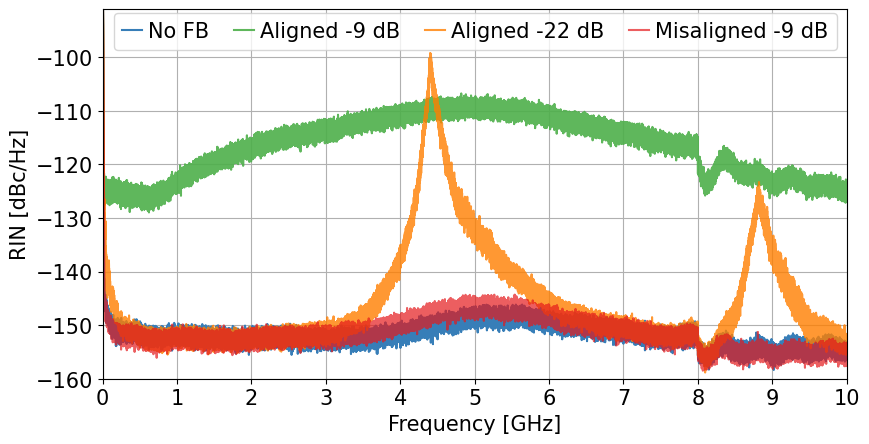

In [16]:
plt.rcParams.update({'font.size': 15})

plot_intensity_data(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-09 GHz")

[[' 111uW output', ' fb = 211uW', ' Gain: 110mA', ' pol: Orthogonal', ' rbw=50Hz', ' counts=20\n']]
not noise free dB [ -72.78061649  -74.56644412  -80.44793674 ... -129.1133649  -128.84551975
 -128.76615115]
50000.0
[[' 111uW output', ' fb = 211uW', ' Gain: 110mA', ' pol: Orthogonal', ' rbw=50Hz', ' counts=20\n']]
not noise free dB [ -90.38143921  -85.30133057  -95.17019653 ... -137.47755432 -138.40756226
 -138.07574463]
Orthogonal -13.231005148169272
200000.0
[[' 111uW output', ' fb = 211uW', ' Gain: 110mA', ' pol: Orthogonal', ' rbw=1000Hz', ' counts=20\n']]
not noise free dB [ -55.70415688 -105.23561859 -106.46160889 ... -130.08661652 -129.60736084
 -130.04175568]
2000000.0
[[' 108.6uW output', ' fb = 206uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=50Hz', ' counts=20\n']]
not noise free dB [ -70.29914447  -71.52665302  -76.34458514 ... -112.85424777 -112.4915311
 -112.12567874]
50000.0
[[' 108.6uW output', ' fb = 206uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=50Hz', ' counts=20\n']]

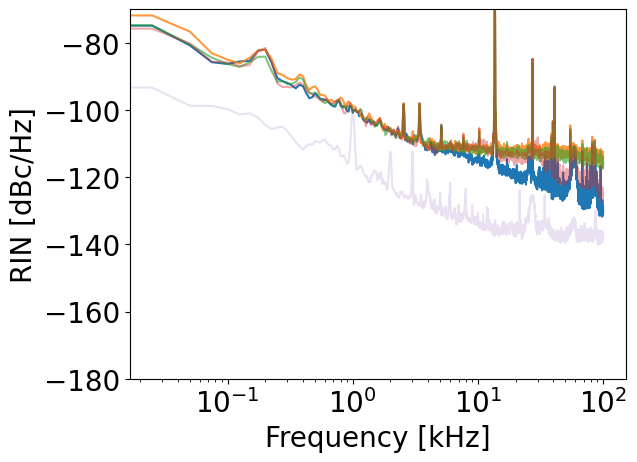

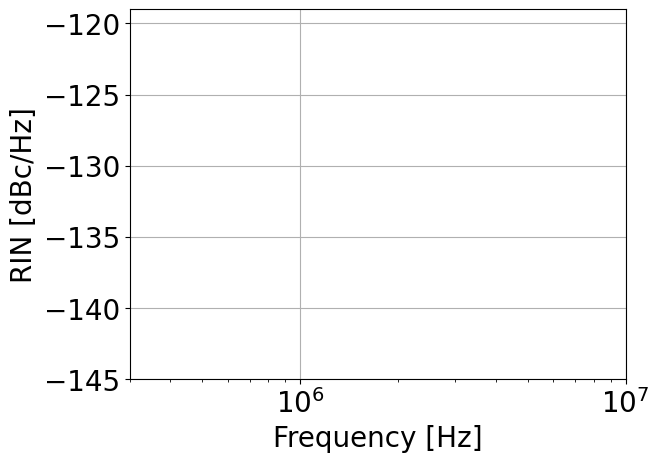

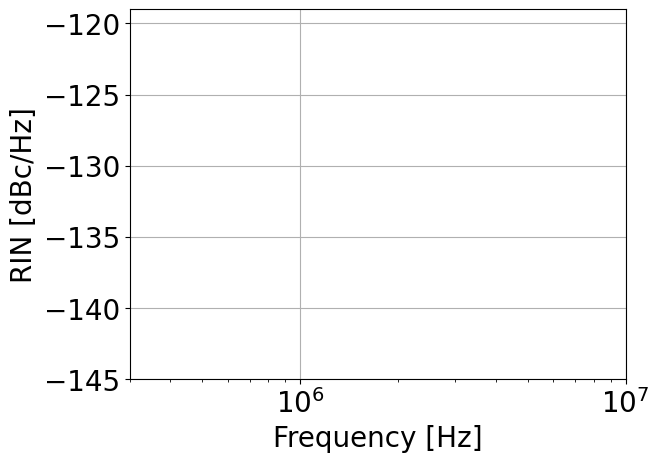

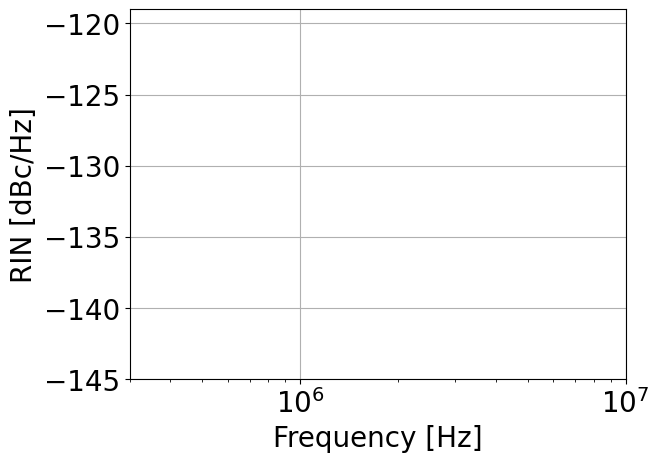

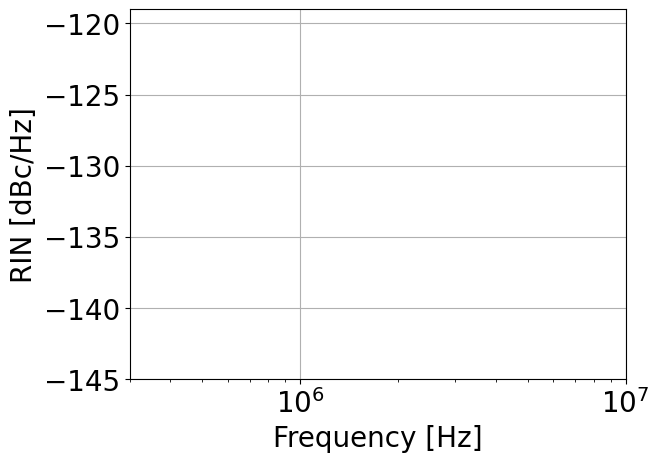

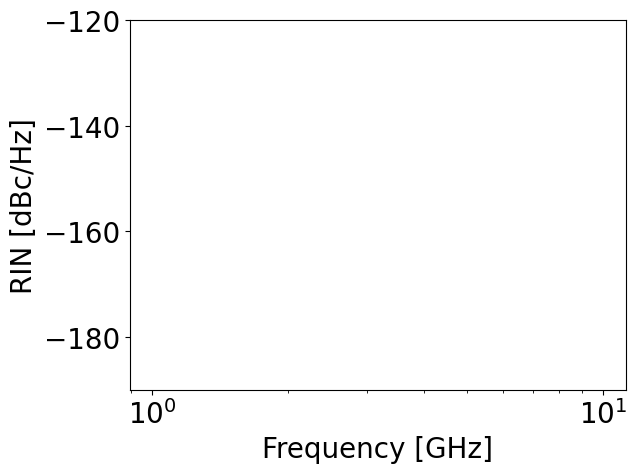

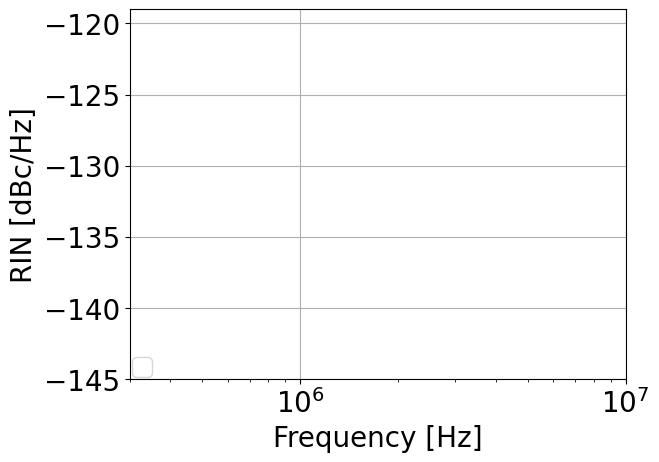

In [68]:
#RIN measurements 24-09

plt.rcParams.update({'font.size': 20})

fb_powers2, single_RIN_values2,_ = plot_intensity_data2(directory2)

[[' 110uW output', ' fb = 51uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [ -81.60937473  -79.77362415  -78.90617725 ... -120.23218509 -119.99341556
 -119.82633945]
Aligned -16.3485250472427
2000000.0
[[' 110uW output', ' fb = 100uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [ -90.24121829  -88.73544284  -87.61949512 ... -120.90271732 -120.45796939
 -120.18550845]
Aligned -13.424226808222063
2000000.0
[[' 110uW output', ' fb = 200uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [ -91.42502567  -90.86546298  -90.23292514 ... -116.35963413 -116.47638675
 -116.68257877]
Aligned -10.41392685158225
2000000.0
[[' 110uW output', ' fb = 284uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [ -88.10875675  -86.74272128  -85.83497974 ... -112.64569827 -112.6419675
 -112.57797977]
Aligned -8.891043407751685
2000000.0
[[' 110uW output', ' fb = 

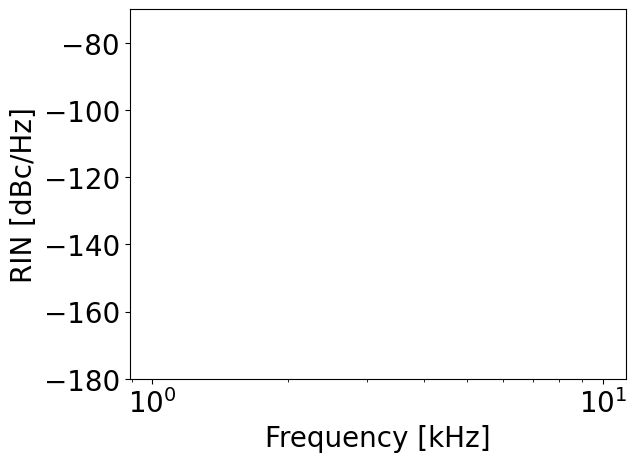

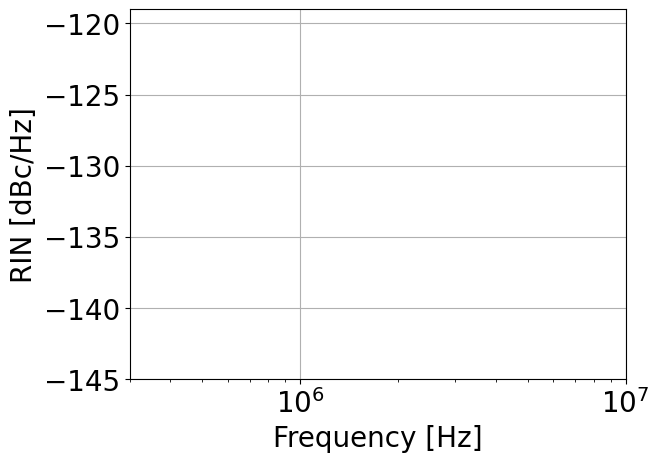

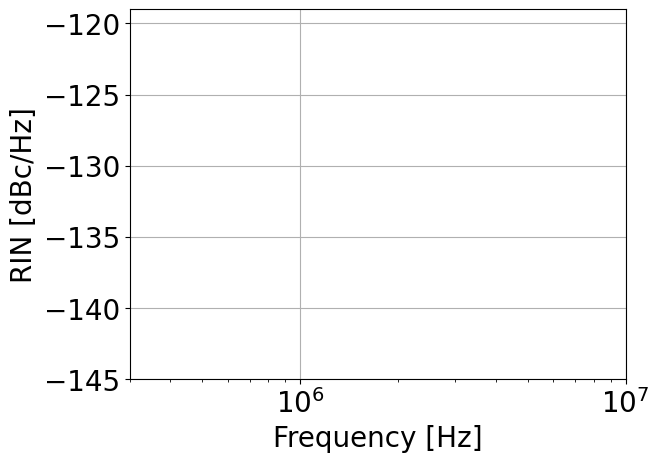

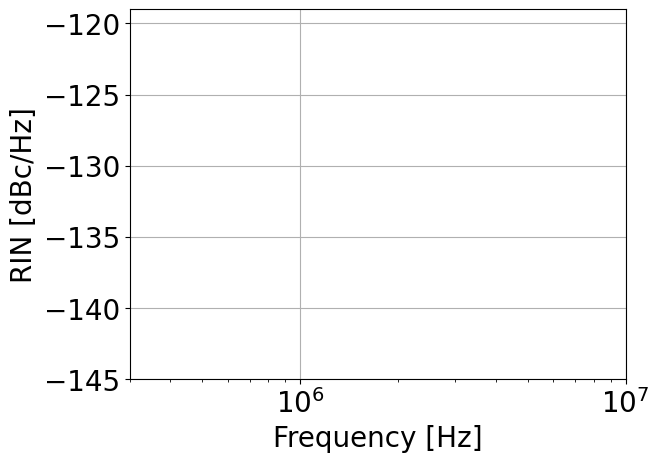

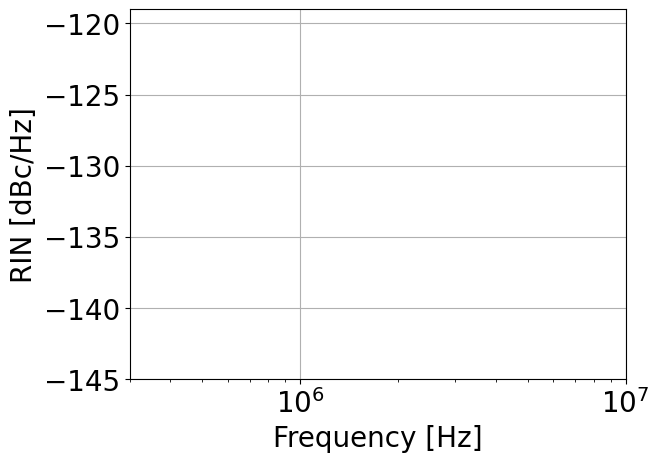

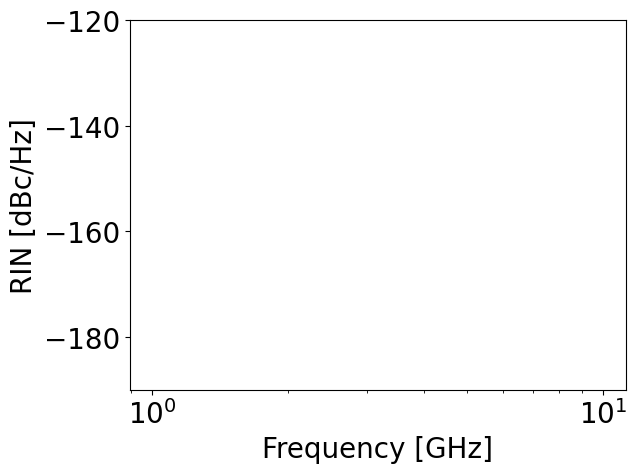

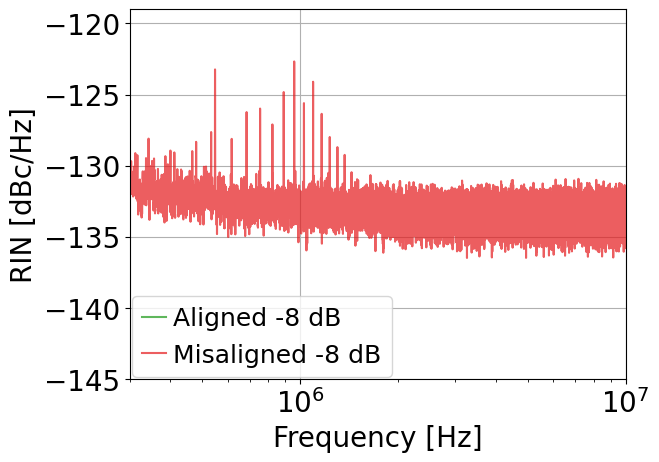

In [111]:
plt.rcParams.update({'font.size': 20})

fb_powers, single_RIN_values, polarizations = plot_intensity_data2(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-9")

In [70]:
polarizations[13]

'Aligned'

[[' 110uW output', ' fb = 93uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [-105.53382083 -106.75586673 -108.9875867  ... -138.32830783 -138.85318729
 -139.33144351]
Aligned -13.739397322682711
2000000.0
[[' 110uW output', ' fb = 200uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [-104.81085941 -106.02110263 -108.23300143 ... -134.05245181 -134.05498477
 -134.27826663]
Aligned -10.41392685158225
2000000.0
[[' 110uW output', ' fb = 400uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [-105.21380588 -106.40862247 -108.58548709 ... -125.73737308 -126.30785342
 -127.05538913]
Aligned -7.403626894942439
2000000.0
[[' 110uW output', ' fb = 50uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=500Hz', ' counts=20\n']]
not noise free dB [-104.38774844 -105.57653781 -107.7417142  ... -140.81186649 -140.49092838
 -140.24363681]
Aligned -16.434526764861875
2000000.0
[[' 110uW output', ' fb 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


not noise free dB [-105.08985111 -106.28704044 -108.47119876 ... -141.42023441 -141.5519025
 -141.69949313]
Background 0.0
2000000.0


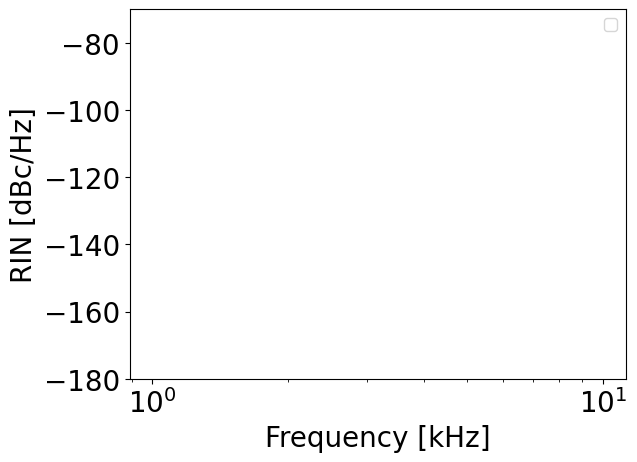

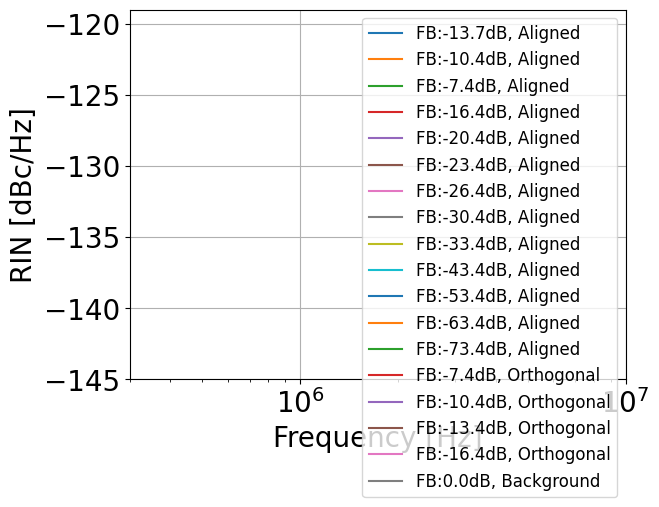

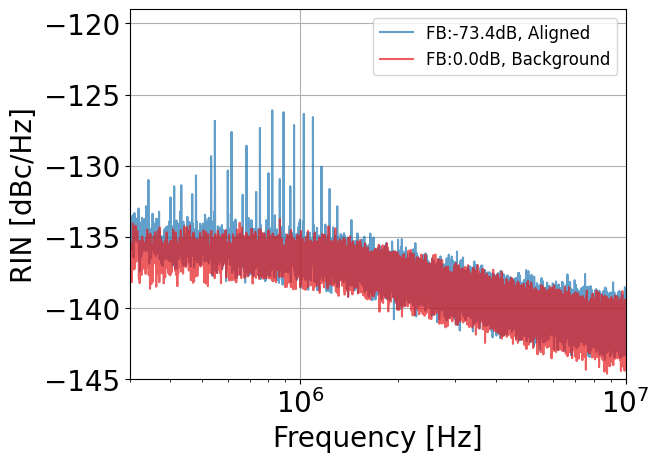

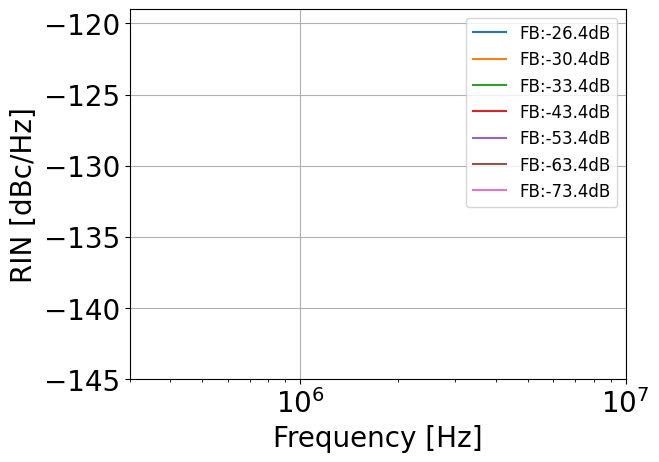

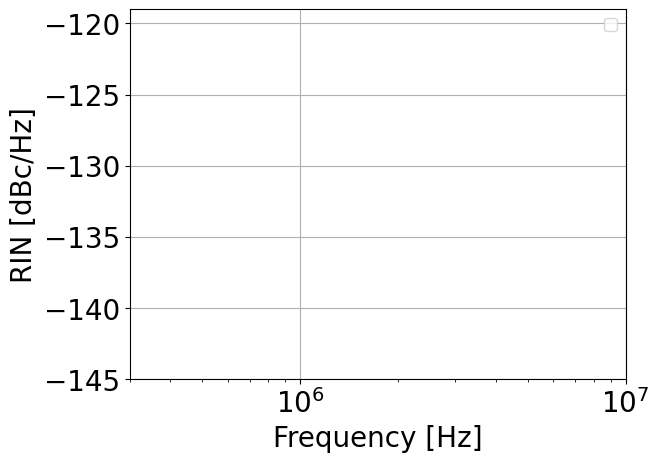

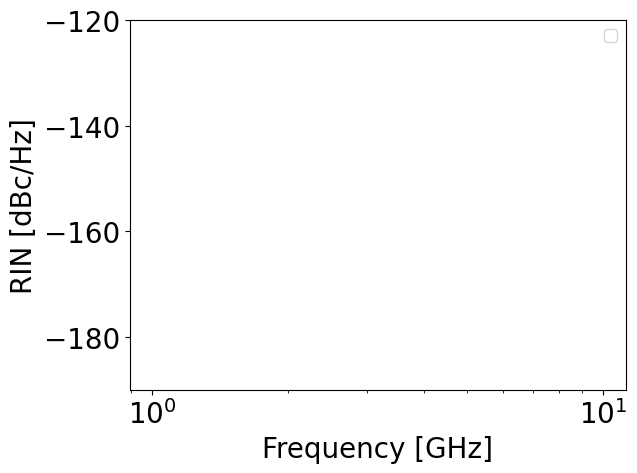

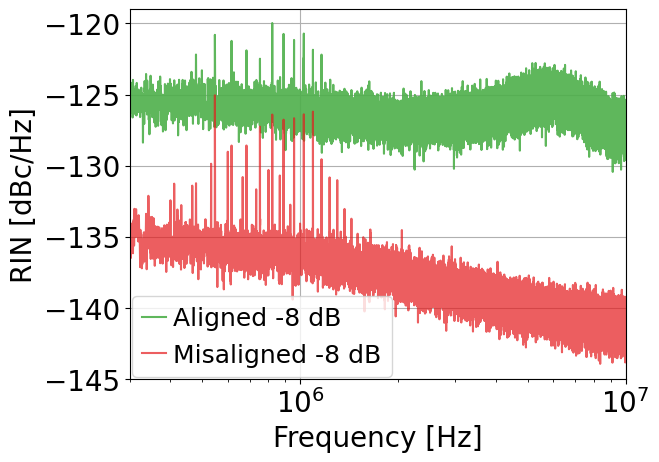

In [175]:
plt.rcParams.update({'font.size': 20})

fb_powers, single_RIN_values, polarizations = plot_intensity_data2(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\3-10")

[[' 98.7uW output', ' fb = 3e-06uW', ' Gain: 110mA', ' pol: None', ' rbw=10000000.0Hz', ' counts=20\n']]
not noise free dB [ -83.17752266  -83.16203213  -83.14770412 ... -150.73471069 -150.31711578
 -150.95328522]
200000000.0
[[' 110.1uW output', ' fb = 624uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=1e7Hz', ' counts=20\n']]
not noise free dB [ -83.28363991  -83.26933384  -83.30262566 ... -120.53643417 -120.55695724
 -120.75090408]
200000000.0
[[' 112.7uW output', ' fb = 46.4uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=10000000.0Hz', ' counts=20\n']]
not noise free dB [ -83.23800659  -83.23500061  -83.22091866 ... -148.49533844 -147.96419525
 -148.91730499]
200000000.0
[[' 113.1uW output', ' fb = 27.6uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=10000000.0Hz', ' counts=20\n']]
not noise free dB [ -83.24409676  -83.22266579  -83.21657562 ... -149.16593933 -147.48187256
 -147.67198181]
200000000.0
[[' 113.0uW output', ' fb = 35.6uW', ' Gain: 110mA', ' pol: Aligned', ' rbw=10000000.0Hz', ' co

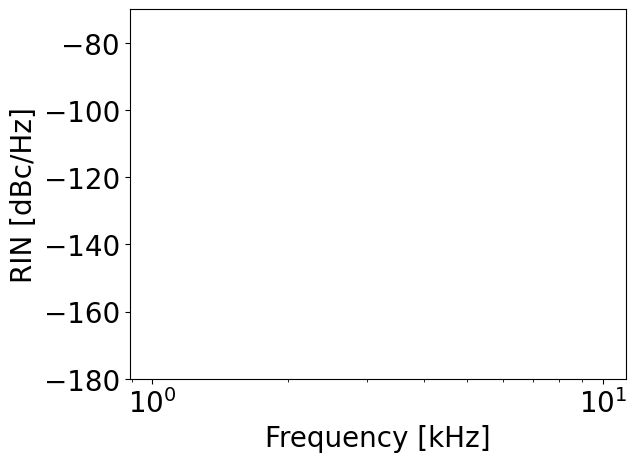

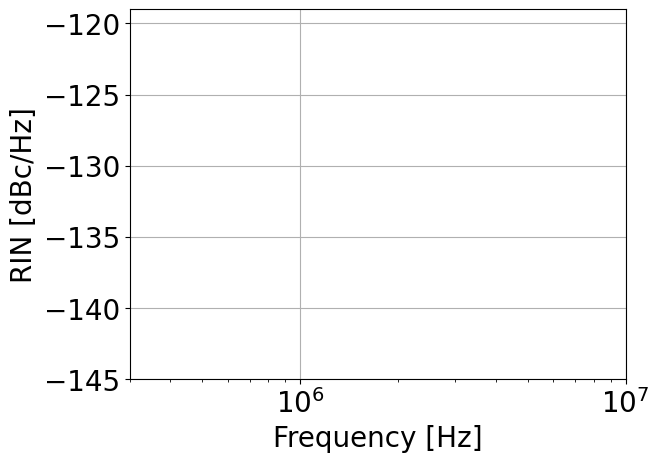

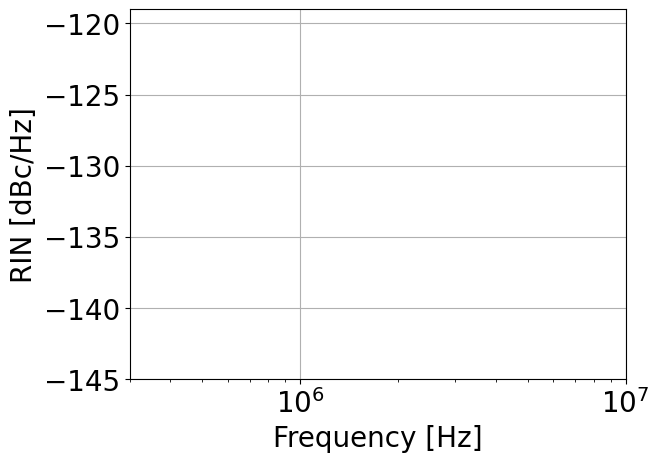

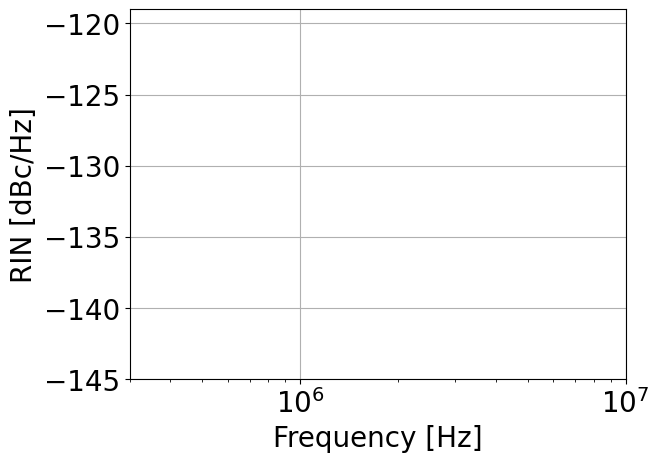

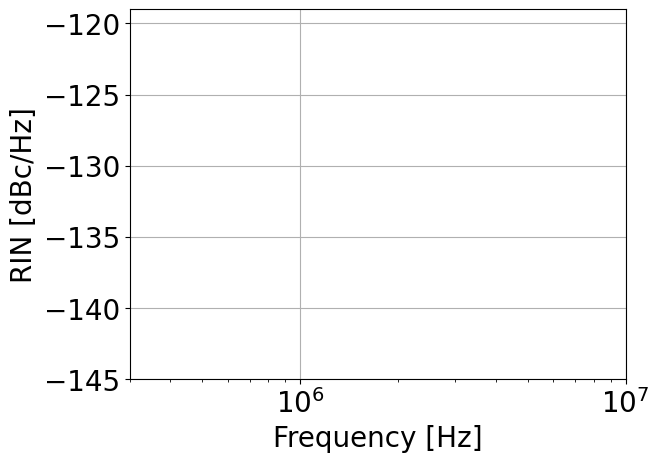

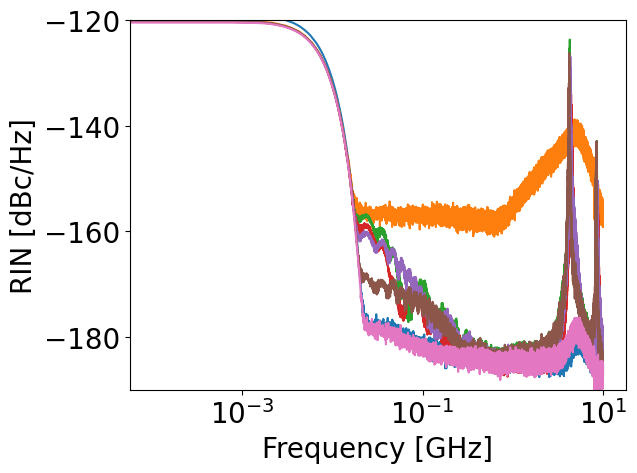

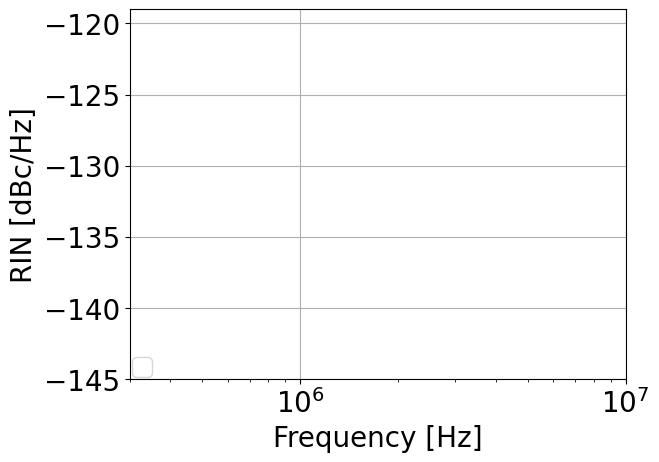

In [72]:
fb_powers2, single_RIN_values2,_ = plot_intensity_data2(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-09 GHz")

In [73]:
polarizations[13:-1]

['Orthogonal', 'Orthogonal', 'Orthogonal', 'Orthogonal']

In [113]:
fb_powers

[-13.739397322682711,
 -10.41392685158225,
 -7.403626894942439,
 -16.434526764861875,
 -20.41392685158225,
 -23.424226808222063,
 -26.434526764861875,
 -30.41392685158225,
 -33.42422680822206,
 -43.424226808222066,
 -53.424226808222066,
 -63.424226808222066,
 -73.42422680822207,
 -7.403626894942439,
 -10.41392685158225,
 -13.424226808222063,
 -16.434526764861875,
 0.0]

([<matplotlib.axis.XTick at 0x1f4d4cd8f20>,
 [Text(-70, 0, '−70'),
  Text(-60, 0, '−60'),
  Text(-50, 0, '−50'),
  Text(-40, 0, '−40'),
  Text(-30, 0, '−30'),
  Text(-20, 0, '−20'),
  Text(-10, 0, '−10')])

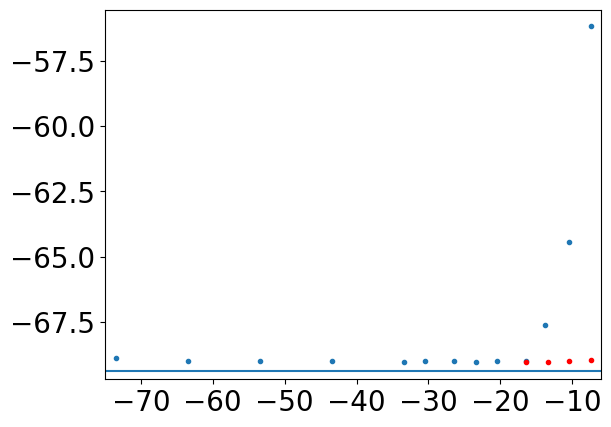

In [125]:

plt.plot(np.array(fb_powers[:13]),single_RIN_values[:13],'.')
plt.plot(np.array(fb_powers[13:-1]),single_RIN_values[13:-1],'r.')

plt.axhline(single_RIN_values[-1])
plt.xlim([-75,-6])
plt.xticks(range(-70,-0,10))


In [124]:
(fb_powers,single_RIN_values,polarizations)

([-13.739397322682711,
  -10.41392685158225,
  -7.403626894942439,
  -16.434526764861875,
  -20.41392685158225,
  -23.424226808222063,
  -26.434526764861875,
  -30.41392685158225,
  -33.42422680822206,
  -43.424226808222066,
  -53.424226808222066,
  -63.424226808222066,
  -73.42422680822207,
  -7.403626894942439,
  -10.41392685158225,
  -13.424226808222063,
  -16.434526764861875,
  0.0],
 [-67.6130420969629,
  -64.44773144586955,
  -56.17560416494711,
  -69.01669102259372,
  -69.0063181541011,
  -69.04416228819015,
  -69.02255828688249,
  -69.01167430459319,
  -69.02861889380452,
  -69.01422039887231,
  -69.0207387519269,
  -69.00142954099466,
  -68.90688147653005,
  -68.97264490647959,
  -69.01160515322866,
  -69.03799221620088,
  -69.0644661143243,
  -69.38006854170843],
 ['Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Aligned',
  'Orthogonal',
  'Orthogonal',
  'Orthogonal',

(300000.0, 10000000.0)

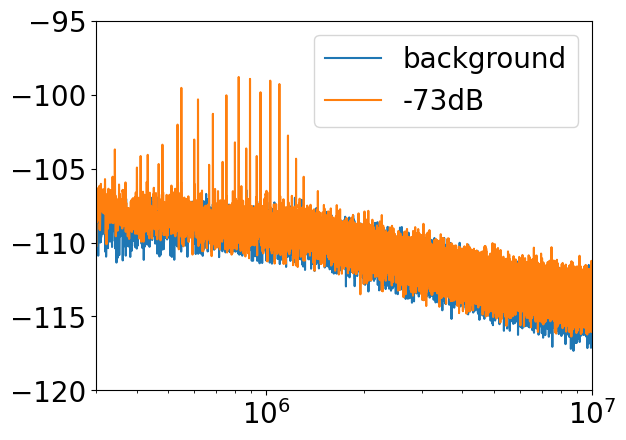

In [77]:
(x,y) = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\3-10\2024-10-03_12-22-23esa.txt")#np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-9\2024-09-26_11-28-59esa.txt")

(x2,y2) = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\3-10\2024-10-03_12-00-08esa.txt")#(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\26-9\2024-09-26_14-09-08esa.txt")


plt.plot(x,y,label='background')
plt.plot(x2,y2,label='-73dB')
plt.legend()
plt.xscale('log')
plt.ylim([-120,-95])
plt.xlim([3e5,1e7])

In [78]:
dir_no = 0


ps_EDFA_free = [None for _ in range(no_RIN_values_EDFA_free)]
fs_EDFA_free = [None for _ in range(no_RIN_values_EDFA_free)]
fb_powers_EDFA_free = [None for _ in range(no_RIN_values_EDFA_free)]


ps_linear_EDFA_free = [[None for _ in range(int(200e3))] for _ in range(no_RIN_values_EDFA_free)]




for i in range(no_RIN_values_EDFA_free):
    
    if dirs[dir_no][0][4][i] != None:

        if dirs[dir_no][0][4][i].header['Outputmode'] == 'RIN mode':
            fs_EDFA_free[i] = dirs[dir_no][0][4][i].freqs
            ps_EDFA_free[i] = dirs[dir_no][0][4][i].powers
            fb_powers_EDFA_free[i] = p_to_micro(dirs[dir_no][0][4][i].fb_power)

            for number, datapoint in enumerate(ps_EDFA_free[i]):
                datapoint_linear = dB_to_linear(datapoint)

                ps_linear_EDFA_free[i][number] = datapoint_linear

            single_RIN_values_EDFA_free[i] = linear_to_dB( sum(ps_linear_EDFA_free[i])*50 ) #Hz, summing all the datapoints and multiplying with the bandwidth, converting to dB

fb_powers_EDFA_free = [float(power) for power in fb_powers_EDFA_free if power != None]
single_RIN_values_EDFA_free = [rin for rin in single_RIN_values_EDFA_free if rin != None]

NameError: name 'no_RIN_values_EDFA_free' is not defined

In [52]:
[x,y] =get_data(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN\2024-08-29_16-14-37esa.txt")

In [ ]:
r

In [9]:
signal.find_peaks_cwt(get_data(paths_intensity[3])[1]*1e-9,0.1)

array([ 7690,  7921,  7923, 14428, 14605, 18177, 37916, 43887, 47542,
       53734, 54387, 57448, 61625, 61787, 66376, 70654, 72863, 73705,
       75873, 80836, 80839, 80864, 80961, 81005, 81030, 81040, 81057,
       81067, 81105, 81119, 81127, 81162, 81179, 81228, 81342, 81375,
       81392, 85736, 85927, 86095, 86138, 86266, 89743, 90164, 90513,
       90550, 90591, 90681, 90690, 90934, 94395, 94817, 95241, 95329,
       95472, 95861, 99597, 99726, 99728], dtype=int64)

In [10]:
xs[81343]

NameError: name 'xs' is not defined

In [ ]:
get_header(paths_intensity[8])

[[' 105.1uW output', ' fb = 10.19uW', ' Gain: 110mA', ' pol: peak minimum\n']]

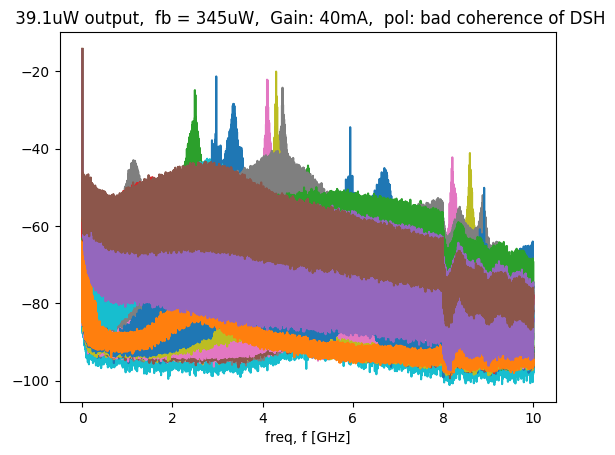

In [ ]:
for i in range(36):
    
    plot_data(paths_intensity[i])

In [ ]:
10**(80/10)*1e-9

0.1

In [ ]:
np.sqrt(1/(10**(-149.13719584/10)/(16*np.pi*1e6)))*1e-9

202.99938382375043

In [31]:
lw_smsr[:,0]

array([9.19960582e+02, 5.73534946e+02, 6.26059042e+02, 2.10127079e+03,
       3.94792682e+03, 3.67445106e+03, 7.68739049e+03, 1.31082527e+03,
       3.95391952e+03, 8.70871277e+02, 8.36711867e+02, 1.88374442e+03,
       1.88600369e+03, 2.19908066e+03, 2.00978056e+03, 4.62542007e+03,
       2.03874002e+03, 2.83129945e+03, 2.32990673e+03, 1.39972835e+03,
       7.46421524e+02, 2.12215740e+03, 8.56592140e+04, 2.12856260e+03,
       9.12478264e+02, 4.93901345e+02, 3.99473171e+02, 6.08639703e+02,
       4.20873031e+02, 5.42587462e+02, 4.07278759e+02, 5.15876403e+02,
       4.45894439e+02, 4.64033768e+02, 5.16387281e+02, 4.65635824e+02,
       5.40748497e+02, 4.63911587e+02, 5.19801943e+02, 5.60619187e+02,
       4.90823323e+02, 5.22381657e+02, 5.26857958e+02, 4.78339739e+02,
       5.43943879e+02, 5.42575105e+02, 7.14515355e+02, 6.07358057e+02,
       4.73248134e+02, 5.35375683e+02, 6.44327193e+02, 5.15587049e+02,
       5.06539408e+02, 4.42614833e+02, 5.29409341e+02, 5.36891322e+02,
      

In [139]:
len(range(33,45))

12

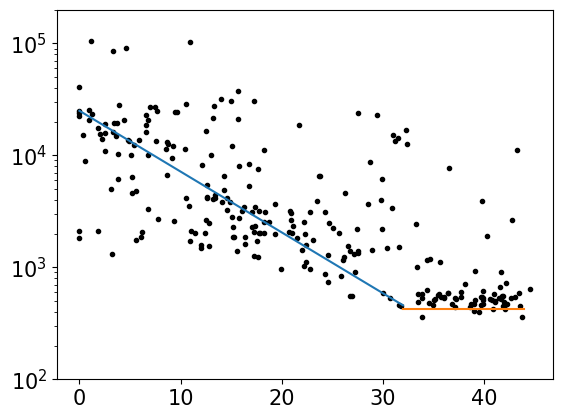

In [154]:
path_to_lw_smsr = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\Crazy good linewidth meas, misaligned fb 109µW_208µW_FB.txt"

lw_smsr = np.loadtxt(path_to_lw_smsr,skiprows=2)

plt.figure()
plt.plot(lw_smsr[:,1],lw_smsr[:,0],'k.')
plt.ylim([100,2e5])
plt.yscale('log')
# plt.hlines(1000,lw_smsr[:,1].min(),lw_smsr[:,1].max())
# plt.vlines(30,lw_smsr[:,0].min(),lw_smsr[:,0].max())
plt.plot(np.array(range(33)),2.5e4*np.exp(-np.array(range(33))/8))
plt.plot(np.array(range(32,45)),np.ones(13)*425)


In [108]:
1e12*np.exp(-lw_smsr[:,1]/2)

array([3.23929162e+03, 5.48348563e+04, 3.48386221e+04, 3.92902732e+09,
       2.27509903e+03, 6.31058980e+05, 1.15406033e+04, 2.04417621e+11,
       3.31122066e+05, 5.39635169e+06, 2.38559249e+06, 2.74189613e+08,
       1.76470886e+03, 1.07819217e+06, 1.39795492e+08, 7.29379687e+10,
       2.02360702e+09, 5.26656201e+08, 1.69161590e+08, 1.05101096e+06,
       4.62453659e+06, 1.00000000e+12, 1.91761732e+11, 3.91996465e+11,
       8.73983805e+02, 7.78553829e+02, 2.65248253e+03, 2.13211635e+03,
       1.32433815e+03, 1.47244951e+04, 3.30383779e+03, 1.55588267e+03,
       8.73400580e+03, 2.36003541e+03, 8.91237740e+02, 3.86963833e+03,
       2.37942795e+03, 2.56362850e+04, 2.30502127e+04, 2.00585407e+04,
       5.25119835e+04, 8.23568147e+03, 4.45609548e+04, 3.03863082e+04,
       1.75554134e+04, 6.48871766e+03, 5.17670403e+03, 6.32735137e+03,
       3.38025453e+03, 2.16120530e+03, 2.07025202e+02, 2.37913872e+04,
       3.24208549e+03, 4.14936662e+03, 5.42871794e+02, 8.43407512e+03,
      

In [65]:
(X,Y) = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\2024-09-24_18-10-52esa.txt",skiprows=1)

In [58]:
t = []
for h,test in enumerate(X):
    
    if h%25==0:
        t.append(test)

In [60]:
t[-5:]

[99900.0, 99925.0, 99950.0, 99975.0, 100000.0]

In [146]:
from uslib import lwa_lib

path_1 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\PSD_s_al_103µW_52µW_FB.txt"
path_2 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\PSD_orth_109µW_208µW_FB.txt"
path_3 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\PSD_alig_110µW_72µW_FB.txt"
path_4 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-09 RIN\PSD_alig_109µW_206µW_FB.txt"

In [190]:
lwa4.path[108:-7]

'206µW'

In [211]:
lwa2.fit_linewidth()

17.55823937785149

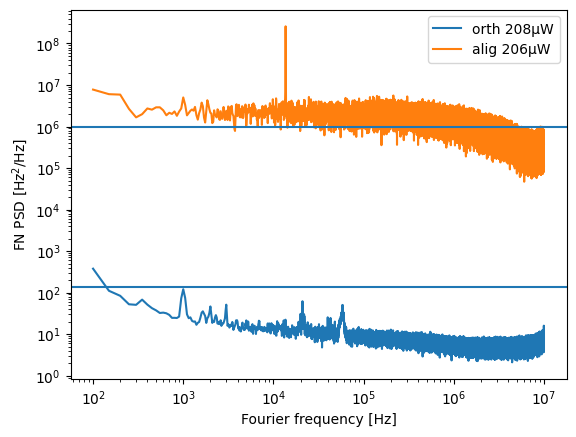

In [213]:
plt.figure(11)
lwa1 = lwa_lib.LWA(path_1)
lwa2 = lwa_lib.LWA(path_2)
lwa3 = lwa_lib.LWA(path_3)
lwa4 = lwa_lib.LWA(path_4)

# lwa1.plot()
# plt.plot(lwa1.freqs,lwa1.powers,label= lwa1.path[97:101] +' '+ lwa1.path[108:-7])
plt.loglog(lwa2.freqs,lwa2.powers,label= lwa2.path[97:101] +' '+ lwa2.path[108:-7])
# plt.plot(lwa3.freqs,lwa3.powers,label= lwa3.path[97:101] +' '+ lwa3.path[108:-7])
plt.loglog(lwa4.freqs,lwa4.powers,label= lwa4.path[97:101] +' '+ lwa4.path[108:-7])

plt.xlabel('Fourier frequency [Hz]')


plt.ylabel('FN PSD [Hz$^2$/Hz]')

plt.axhline(y=135)
plt.axhline(y=981000)

# plt.loglog(self.freqs, self.powers*factor,label=label)



plt.legend()